**PROJET D'AMELIORATION DE LA BASE DE DONNEES OPEN FOOD FACT**

Ce nootebook présente un travail d'exploration et d'analyse de la base de données de [Open food fact](https://world.openfoodfacts.org/) dans l'objectif de proposer un outil d'auto-completion dans la saisie de produits alimentaires et du calcul des nutri-score associés.

# IMPORT DES DONNEES

Les bibliothèques suivantes seront nécessaires aux premiers traitements. D'autres packages seront importés plus bas selon les besoins.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
df_bis=pd.read_csv('/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 3/openfoodfact_products.csv',sep='\t')

<ipython-input-20-80e681e401d6>:1: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bis=pd.read_csv('/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 3/openfoodfact_products.csv',sep='\t')


In [25]:
# création d'une copie du dataframe afin de garder une références non modifié tout au long des traitements appliqués
df_work=df_bis.copy()

# NETTOYAGE DES DONNEES

## SUPPRESSION DES VARIABLES VIDES A PLUS DE 60 %

In [ ]:
# on récupère les colonnes ayant plus de 60% de NaN
D_NaN=df_work.isna().mean()
list_NaN_60=D_NaN.loc[D_NaN>0.6].index.tolist()

# puis on les retire du df_work
df_work=df_work.loc[:,~df_work.columns.isin(list_NaN_60)]
df_work.head()

code                                                url  \
0   3087  http://world-fr.openfoodfacts.org/produit/0000...   
1   4530  http://world-fr.openfoodfacts.org/produit/0000...   
2   4559  http://world-fr.openfoodfacts.org/produit/0000...   
3  16087  http://world-fr.openfoodfacts.org/produit/0000...   
4  16094  http://world-fr.openfoodfacts.org/produit/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
2             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
3             usda-ndb-import  1489055731  2017-03-09T10:35:31Z   
4             usda-ndb-import  1489055653  2017-03-09T10:34:13Z   

  last_modified_t last_modified_datetime                    product_name  \
0      1474103893   2016-09-17T09:18:13Z              Farine de blé noir   
1      1489069957   2017-03-09T14:32:37Z  Banana Chips Sweetened (Whole)   
2      1489069957   2017-03-09T14:32:37Z                         Peanuts   
3      1489055731   2017-03-09T10:35:31Z          Organic Salted Nut Mix   
4      1489055653   2017-03-09T10:34:13Z                 Organic Polenta   

            brands      brands_tags  ... fiber_100g proteins_100g salt_100g  \
0  Ferme t'y R'nao  ferme-t-y-r-nao  ...        NaN           NaN       NaN   
1              NaN              NaN  ...        3.6          3.57   0.00000   
2   Torn & Glasser     torn-glasser  ...        7.1         17.86   0.63500   
3        Grizzlies        grizzlies  ...        7.1         17.86   1.22428   
4   Bob's Red Mill   bob-s-red-mill  ...        5.7          8.57       NaN   

  sodium_100g vitamin-a_100g  vitamin-c_100g calcium_100g iron_100g  \
0         NaN            NaN             NaN          NaN       NaN   
1       0.000            0.0          0.0214        0.000   0.00129   
2       0.250            0.0          0.0000        0.071   0.00129   
3       0.482            NaN             NaN        0.143   0.00514   
4         NaN            NaN             NaN          NaN       NaN   

  nutrition-score-fr_100g  nutrition-score-uk_100g  
0                     NaN                      NaN  
1                    14.0                     14.0  
2                     0.0                      0.0  
3                    12.0                     12.0  
4                     NaN                      NaN  

[5 rows x 42 columns]

## EXPLORATION DES REMPLISSAGES AVEC MISSINGNO

In [ ]:
import missingno as msno

<Axes: >

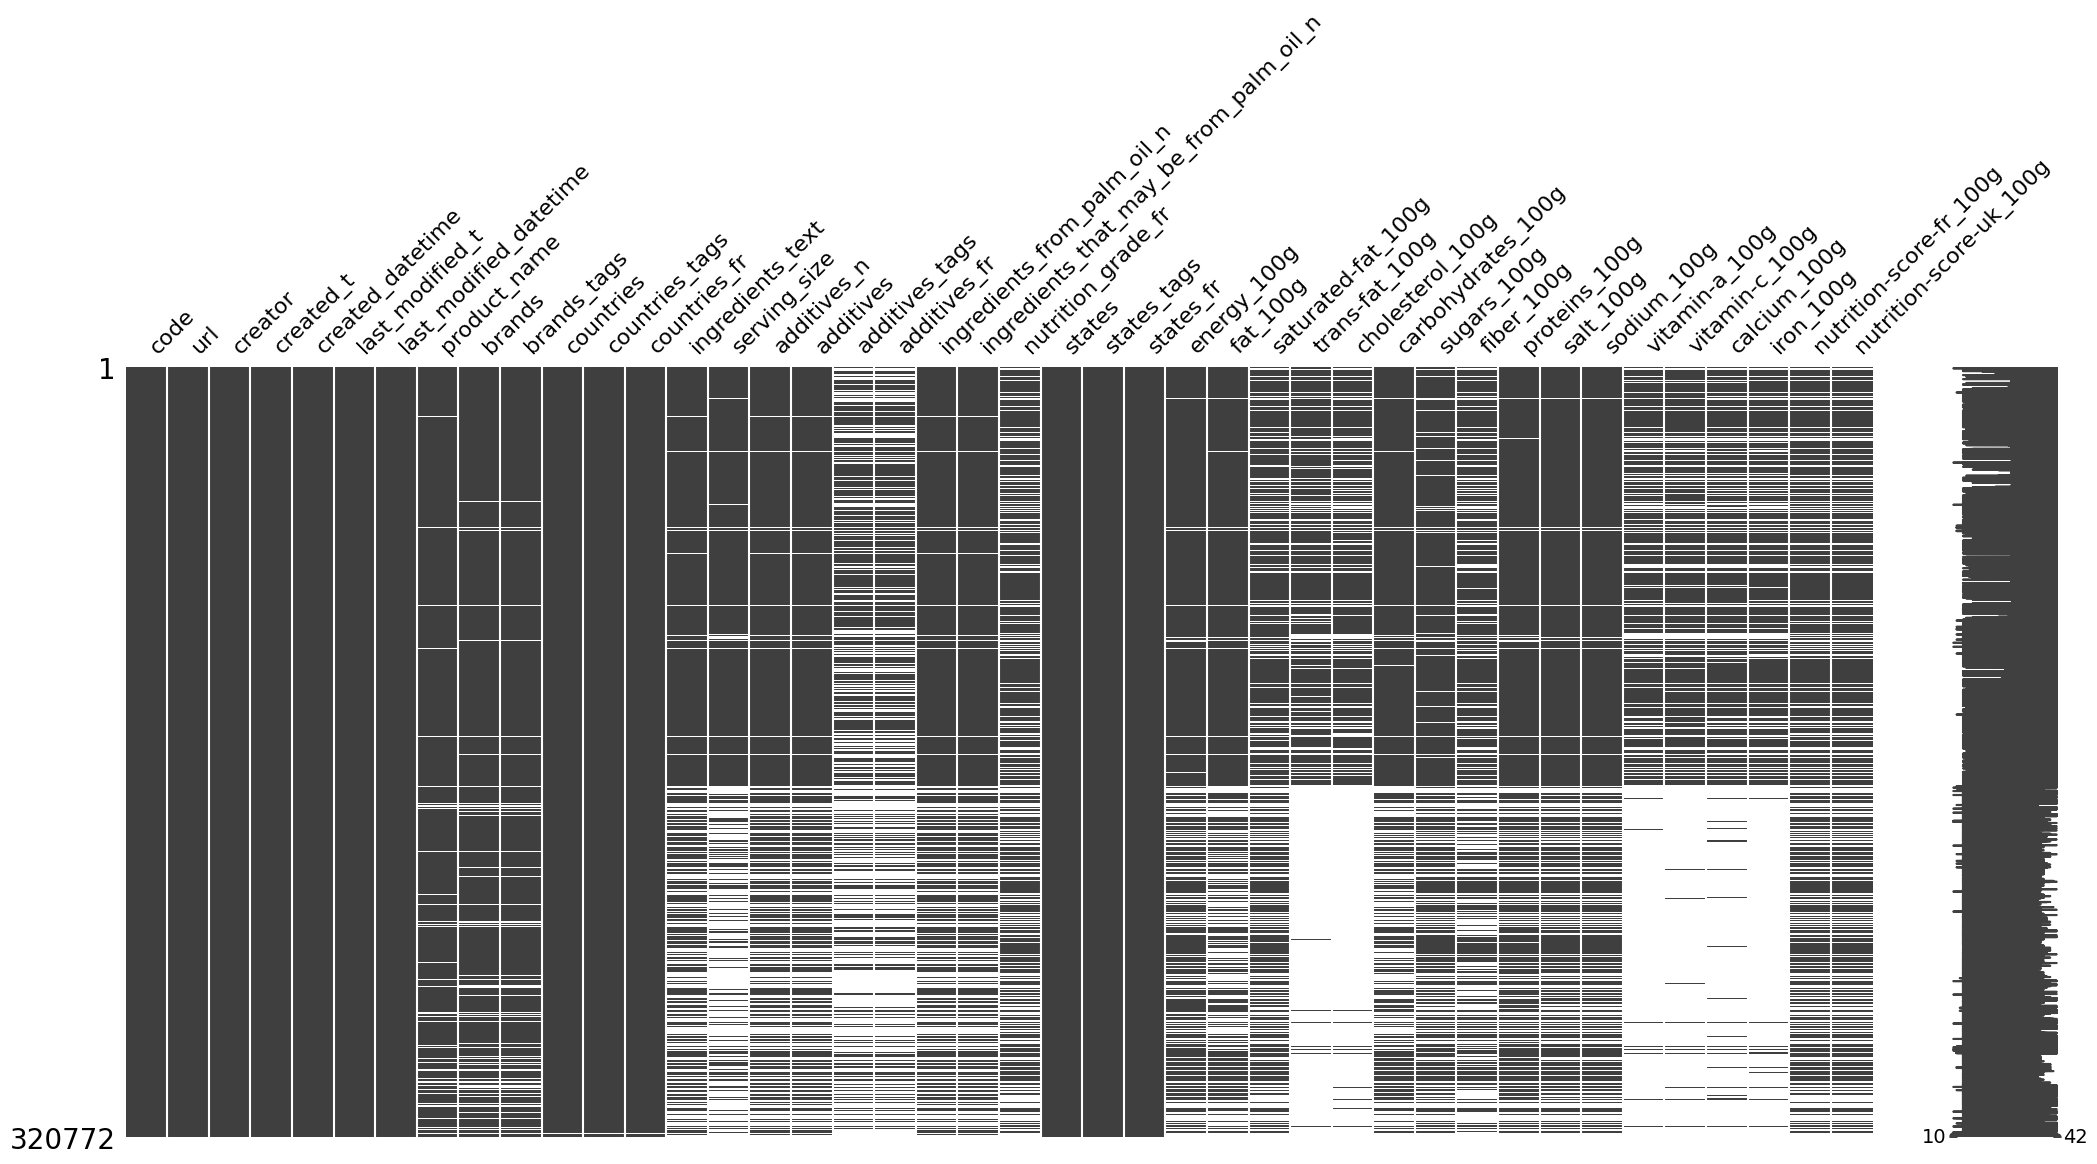

In [ ]:
msno.matrix(df_work)

La matrice ci-dessus nous donne une première illustration de comment sont remplies les donnnées. Dans le cas de notre étude, ce sont principalement les colonnes des variables nutritionnelles et celle des nutri-score qui vont nous intéresser.

## TRAITEMENT DES VARIABLES NUTRITIONNELLES

### EXTRACTION DES VARAIBLES NUTRITIONNELLES

In [ ]:
# créer une liste qui extrait uniqueùent les variables nutritionnelles
list_nutri=df_work.loc[:,df_work.columns.str.endswith('100g')].columns.tolist()[:-2] # ne prend pas les nutri-scores
list_nutri=list_nutri[1:] # ne prend pas energy_100g qui n'est pas en g mais en kJ
list_nutri

['fat_100g',
 'saturated-fat_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'vitamin-a_100g',
 'vitamin-c_100g',
 'calcium_100g',
 'iron_100g']

### TRAITEMENT DES OUTLIERS PAR CONNAISSANCE METIER

Nous n'avons pas beaucoup de connaissance métier sur les données.
Cependant par culture générale et quelques recherches nous pouvons estimer certaines valeur limites pour les variables fiber_100g et energy_100g :

Nous fixerons la valeur maximale de energy_100g à 3 770 kJ (correspondant à l'huile contenant 100 % de lipides, voir [ici](https://sante.journaldesfemmes.fr/fiches-nutrition/2657523-quels-aliments-les-plus-caloriques-a-eviter/#:~:text=L'aliment%20%C3%A0%20la%20densit%C3%A9,moins%20calorique%20que%20les%20autres.))

Aussi nous savons que la somme des valeurs nutritionnelles pour un produit ne doit pas exéder 100 g. Nous prendrons une marge de 5 g dans ce traitement.
De plus, une valeur nutritionnelle ne peut être négative.

#### Valeurs négatives et supérieures à 100 g

In [ ]:
# passe à NaN les valeurs négatives et supérieures à 100 g pour chaque variable nutritive
for nutri in list_nutri:
  df_work.loc[(df_work[nutri]>100) | (df_work[nutri]<0),nutri]=np.NaN

#### energy_100g supérieur à 3 770 kJ

In [ ]:
df_work.loc[df_work['energy_100g']>3770,'energy_100g']=np.nan
df_work['energy_100g'].describe()

count    260753.000000
mean       1121.513410
std         792.474469
min           0.000000
25%         375.000000
50%        1100.000000
75%        1674.000000
max        3770.000000
Name: energy_100g, dtype: float64

#### Sommes des valeurs nutritionnelles supérieures à 105 g

Note : nous savons aussi que les acides gras saturés et trans renseignés sur une produit sont généralement compris dans les acides gras du produit. Nous allons donc les retirer des variables temporairement pour ce nettoyage.

NB : la cellule ci-dessous confirme l'hypothèse ci-dessus dans le cas des cacahuètes qui en moyennes dans les données ont 42 % de fat et 6.5 % de satured fat ce qui est le même ordre de grandeur lisible [sur wikipédia](https://fr.wikipedia.org/wiki/Arachide) qui inclut le satured dans la fat.

In [ ]:
# NB : saturées inclut dans fat
df_work.loc[df_work['product_name']=="Peanuts",['fat_100g','saturated-fat_100g','trans-fat_100g']].mean()

fat_100g              42.199123
saturated-fat_100g     6.482281
trans-fat_100g         0.000000
dtype: float64

In [ ]:
# copie la liste des variables nutriments sans les graisses saturées
list_nutri_wo_sat=[list_nutri[0]]+list_nutri[3:]
list_nutri_wo_sat

['fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'vitamin-a_100g',
 'vitamin-c_100g',
 'calcium_100g',
 'iron_100g']

In [ ]:
# passe à NaN les lignes nutritions dont la somme dépasse 105 g
df_work.loc[df_work[list_nutri_wo_sat].sum(axis=1)>105,list_nutri_wo_sat]=np.nan

### TRAITEMENT DES OUTLIERS PAR LA STATISTIQUE

#### Analyse entre deux méthodes

Nous allons créer une fonction qui mesure l'impacte sur le nombre de valeurs aberrantes détecté et sur la distribution de chaque variable entre une méthode basé sur les interquartiles et une autre basée sur les écart-types.

In [ ]:
# nombre de varibale à traiter
len(list_nutri)

14

In [ ]:
def Min_Max_quartile(serie):
  """
  renvoi un tuple dont 0 est le min et 1 est le max via méthode interquartiles
  """
  q1,q3=np.quantile(serie.dropna(),[.25,.75])
  dIQ=1.5*(q3-q1)
  return((q1-dIQ,q3+dIQ))

In [ ]:
def Min_Max_sigma(serie):
  """
  renvoi un tuple dont 0 est le min et 1 est le max basé sur écart à 3 sigma de la moyenne
  """
  sig=np.std(serie.dropna())
  mean=np.mean(serie.dropna())
  return((sig-3*mean,sig+3*mean))

In [ ]:
def Outlier_to_Nan(serie,min_value,max_value):
  """
  renvoi la même serie avec les valeurs inférieures à min_value ou supérieures à max_value passées à NaN
  """
  serie=serie.dropna()
  serie.loc[(serie>max_value) | (serie<min_value)]=np.nan
  return(serie)

In [ ]:
def Plot_Outlier_Treatment(list_variables,ApplyResult=0):
  """
  Trace pour chaque varible la distribution pour les deux méthodes de traitement des outliers
  ApplyResult = 0 : n'applique aucune modif ; 1 : applique distribution méthode IQ ; 2 : applique sigma
  """

  # _____calcul des distributions___________
  array_to_plot=[] # prendra [[distrib_source distrib_IQ distrib_sigma] [...] [...]]
  for nutri in list_nutri:

    serie=df_work[nutri].copy()
    dist_IQ=Outlier_to_Nan(serie,Min_Max_quartile(serie)[0],Min_Max_quartile(serie)[1])
    dist_sigma=Outlier_to_Nan(serie,Min_Max_sigma(serie)[0],Min_Max_sigma(serie)[1])

    array_to_plot.append([serie.dropna(), dist_IQ.dropna(), dist_sigma.dropna()])

  #_______application des distributions calulées selon méthode_______
    match ApplyResult:
      case 1:
        df_work[nutri]=dist_IQ
      case 2:
        df_work[nutri]=dist_sigma

  # _______plot des distributions______________
  plt.figure(figsize=(10,20))

  for n in range(len(list_nutri)):
    plt.subplot(7,2,n+1)
    plt.title(f"Distributions {list_nutri[n]}",fontsize=10)
    plt.grid()
    plt.boxplot(array_to_plot[n],vert=True,showmeans=True,showfliers=False,positions = [1, 2,3],patch_artist = True,labels=['source','IQ','sigma'])
    plt.gcf().subplots_adjust(hspace = 0.5)
    for i in range(0,3):
      plt.text((i+1)-0.3,np.quantile(array_to_plot[n][i],.75),f"shape = {array_to_plot[n][i].shape[0]}",fontsize=6)

  plt.show()

IndexError: ignored

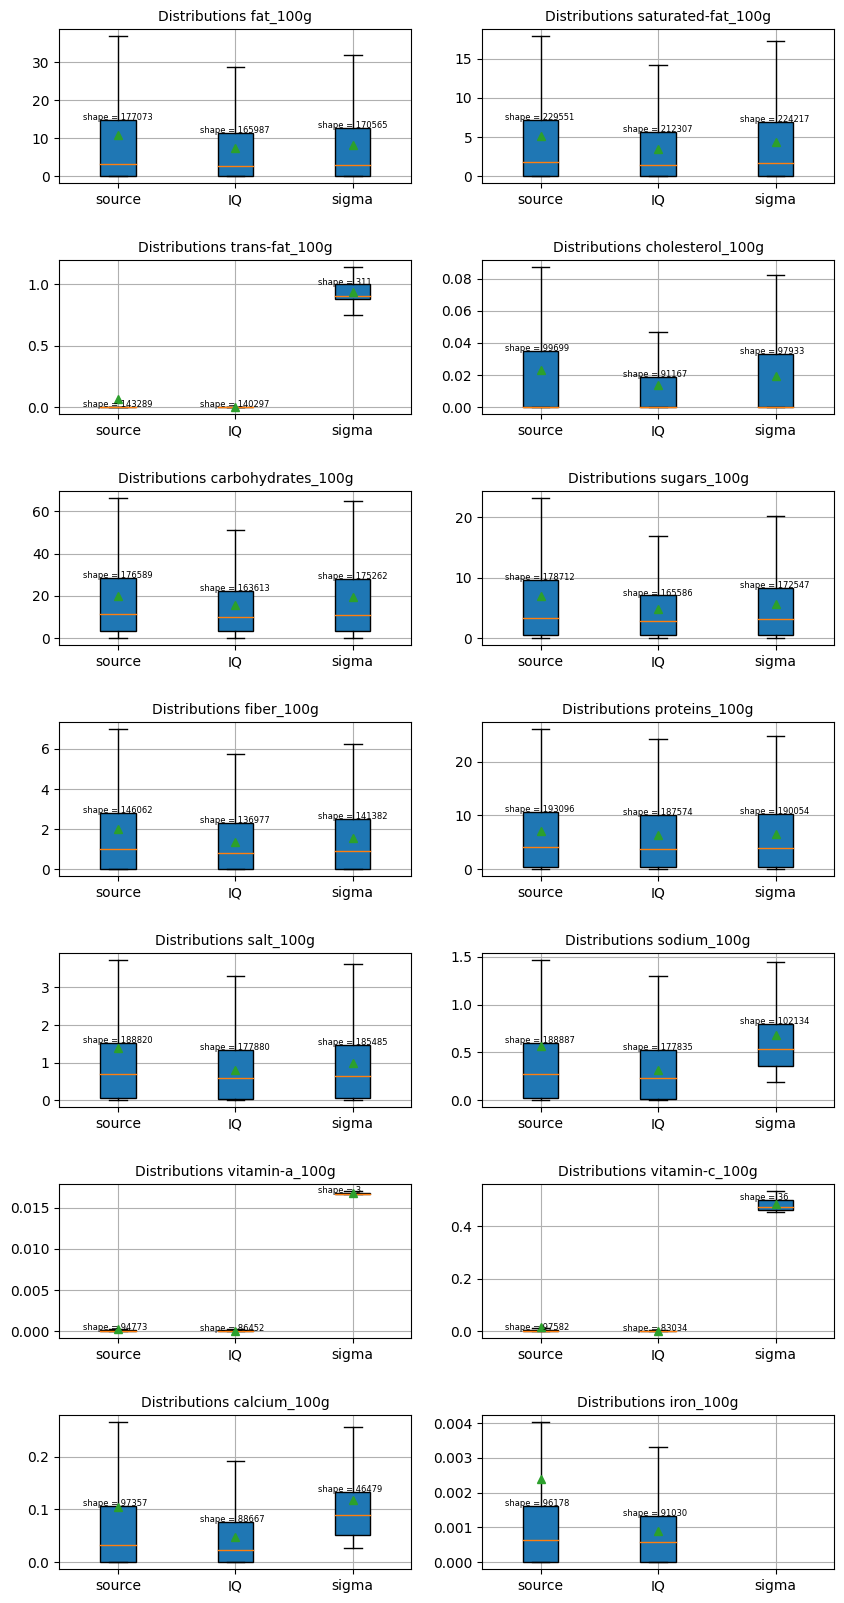

In [ ]:
Plot_Outlier_Treatment(list_nutri)

Dans la plupart des cas la méthode des écart-type modifie beaucoup trop les distributions des variables.

En effet par exemple pour le fer, la distribution étant peu équilibré de base, supprimer des valeurs en se basant sur l'écart à la moyenne supprime carrément toute la série...

In [ ]:
df_work['iron_100g'].describe()

count    96178.000000
mean         0.002395
std          0.163354
min          0.000000
25%          0.000000
50%          0.000640
75%          0.001610
max         47.058820
Name: iron_100g, dtype: float64

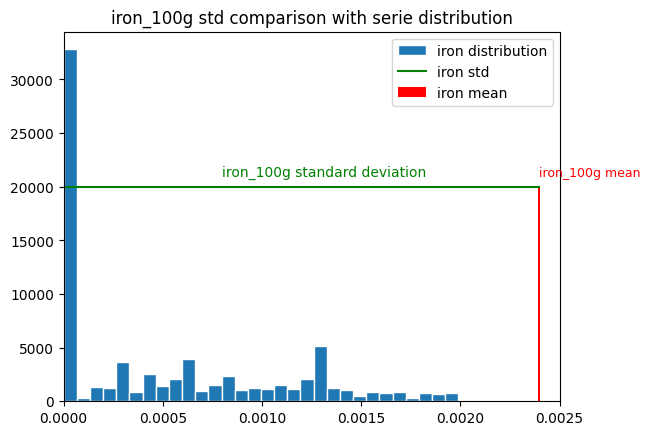

In [ ]:
x = df_work['iron_100g'].loc[df_work['iron_100g']<0.002]
mean=df_work['iron_100g'].mean()
std=df_work['iron_100g'].std()

plt.hist(x,30 ,edgecolor = 'white', label='iron distribution')

plt.bar(x=mean,height=20000,color='red',width=0.00001, label='iron mean')
plt.text(x=mean,y=21000,s='iron_100g mean',fontsize=9,color='red')

plt.plot([mean-std, mean],[20000,20000], color='green', label='iron std')
plt.text(x=mean/3,y=21000,s='iron_100g standard deviation', color='green')

plt.xlim(0,0.0025)
plt.title('iron_100g std comparison with serie distribution')

plt.legend()
plt.show()

Je vais retenir la méthode de inter-quartiles.

IndexError: ignored

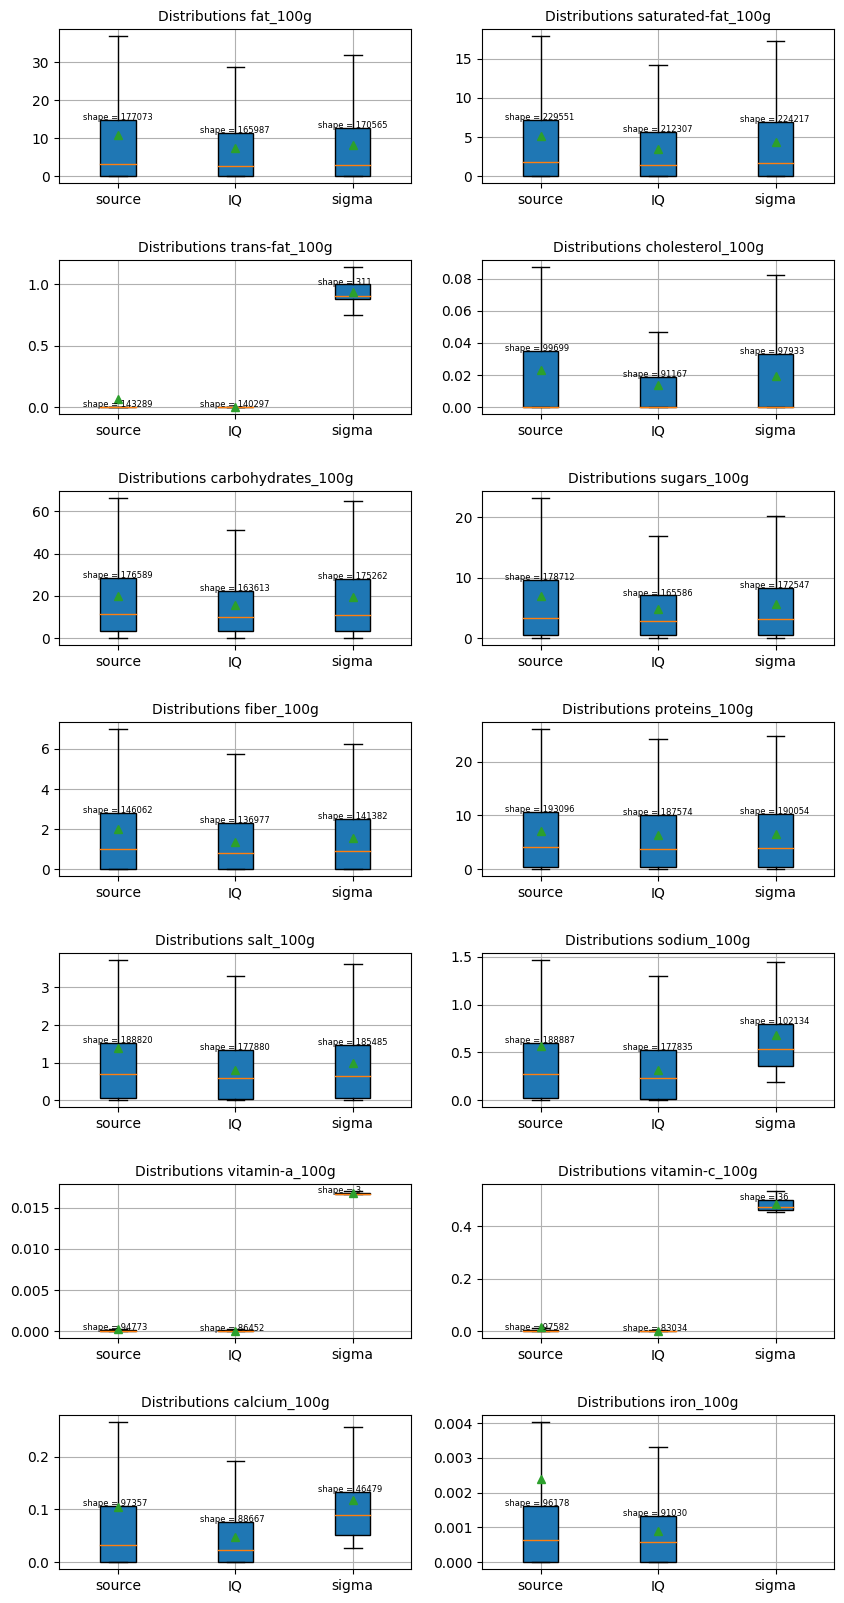

In [ ]:
# on applique le filtre par inter-quartile avec l'argument ApplyResult = 1
Plot_Outlier_Treatment(list_nutri,ApplyResult=1)

On peut noter que l'erreur qui s'affiche à l'exécution de cette fonction ne perturbe pas les calculs dans notre cas. Cette erreur apparaît à l'étape d'affichage de la variable iron_100g après suppression des valeurs à plus de 3 écart-types. Comme cet affichage est le dernier du processus cela n'impacte pas les calculs précédents.

#### Nouvelle suppression par taux de remplissage

En supprimant les outliers certaines variables voient leur population chuter. Elles ne seront pas exploitable pour la suite :

In [ ]:
D=df_work.isna().mean().sort_values()
print(f"Les variables suivantes vont être supprimées : \n\n{D.loc[D>0.6]}")

Les variables suivantes vont être supprimées : 

cholesterol_100g    0.715789
iron_100g           0.716216
calcium_100g        0.723582
vitamin-a_100g      0.730488
vitamin-c_100g      0.741143
dtype: float64


In [ ]:
# suppression de ces colonnes du df_work
list_to_suppr=D.loc[D>0.6].index.tolist()
df_work=df_work.loc[:,~df_work.columns.isin(list_to_suppr)]

In [ ]:
df_work.shape

(320772, 37)

# IMPUTATION DES VALEURS MANQUANTES

## REMPLISSAGE PAR IterativeImputer

In [ ]:
# comme iterative imputer est encore experimentale (le code evolue encore selon les versions) il faut d'abord importer le module expérimentale ci-dessous
from sklearn.experimental import enable_iterative_imputer
# avant d'importer Iterative Imputer
from sklearn.impute import IterativeImputer

### Estimateur Ridge pour les variables corrélées

In [ ]:
from sklearn.linear_model import LinearRegression,BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

#### Détection des variables corrélées

Dans un premier temps nous allons extraire les couples de variables qui sont corrélées à au moins 70 % entre elles.

In [ ]:
# la tables des corrélations de pearson
df_corr=df_work.dropna().corr('pearson')

<ipython-input-30-ed6970946462>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr=df_work.dropna().corr('pearson')


<Axes: >

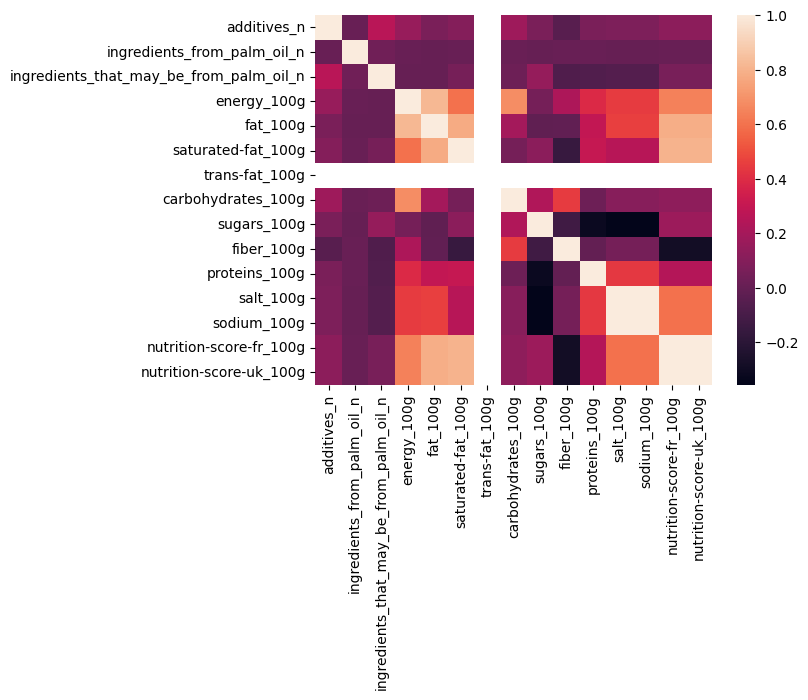

In [ ]:
# visualisation graphique pour avoir une vue d'ensemble
sns.heatmap(df_corr)

In [ ]:
# création de la liste des couples de variables nutritives corrélées à au moins 70% en valeur absolue
AB=df_corr.index.tolist()
list_couple=[(a,b) for a in AB for b in AB if (np.abs(df_corr.loc[a,b])>=0.7) and (a!=b) and ('nutrition' not in a) and ('nutrition' not in b)]
list_couple_corr=[]
for i in range(1,len(list_couple)-2):
  list_couple_corr.append(list_couple[2*i-1])

list_couple_corr

[('fat_100g', 'energy_100g'),
 ('saturated-fat_100g', 'fat_100g'),
 ('sodium_100g', 'salt_100g')]

In [ ]:
list_couple

[('energy_100g', 'fat_100g'),
 ('fat_100g', 'energy_100g'),
 ('fat_100g', 'saturated-fat_100g'),
 ('saturated-fat_100g', 'fat_100g'),
 ('salt_100g', 'sodium_100g'),
 ('sodium_100g', 'salt_100g')]

#### Scatterplot des variables corrélées

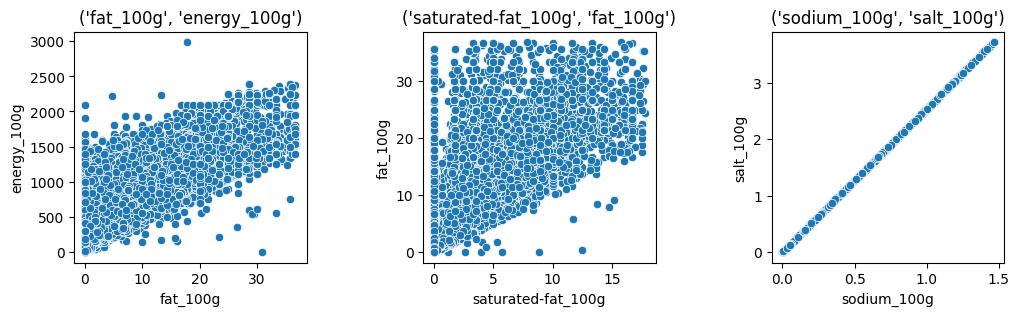

In [ ]:
plt.figure(figsize=(12,3))
for k in range(1,4):

  plt.subplot(1,3,k)
  sns.scatterplot(x=df_work.dropna()[list_couple_corr[k-1][0]],y=df_work.dropna()[list_couple_corr[k-1][1]])
  plt.title(list_couple_corr[k-1])
  plt.xlabel(list_couple_corr[k-1][0])
  plt.ylabel(list_couple_corr[k-1][1])
  plt.gcf().subplots_adjust(wspace = 0.5)

plt.show()

Les deux premiers plot sembles ne pas avoir de bonne corrélation linéaire mais ont pourtant un bon coefficient de pearson.

In [ ]:
from scipy.stats import pearsonr
corr, _ = pearsonr(df_work.dropna()['fat_100g'], df_work.dropna()['saturated-fat_100g'])

Text(20, 10, 'pearson = 0.78')

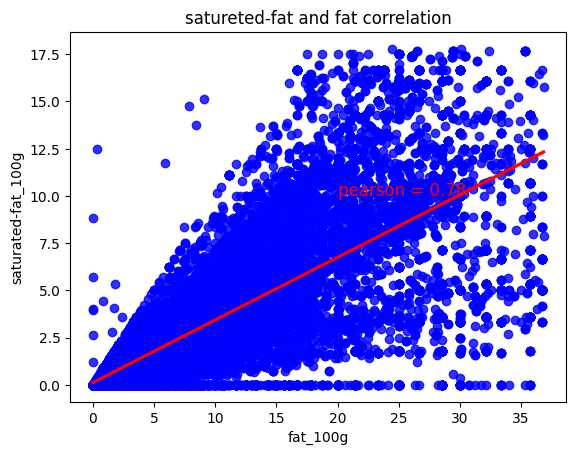

In [ ]:
sns.regplot(x=df_work.dropna()['fat_100g'],y=df_work.dropna()['saturated-fat_100g'],color='blue',line_kws=dict(color="r"))
plt.title('satureted-fat and fat correlation')
plt.text(x=20,y=10,s=f"pearson = {round(corr,2)}",color='red', fontsize=12)

#### Imputation

Les variables linéairement corrélées seront comblées par simple réfression linéaire.

In [ ]:
# transforme les tuples en listes dans list_couple_corr
Listed_couple_corr=[[a,b] for a,b in list_couple_corr]

La cellule suivante permet de comparer les distributions de chaque variable avant et après imputation des valeurs manquantes selon que l'on utilise la médiane ou la moyenne.

In [ ]:
def LinearImputerCouple(list_couple):
  # création des imputers
  imputer_linear=IterativeImputer(estimator=BayesianRidge(),initial_strategy='median')
  imputer_linear_mean=IterativeImputer(estimator=BayesianRidge(),initial_strategy='mean')

  plt.figure(figsize=(10,15))

  for couple_id in range(len(list_couple)):
    # impute le couple______________
    Y=imputer_linear.fit_transform(df_work[list_couple[couple_id]])
    Yn=imputer_linear_mean.fit_transform(df_work[list_couple[couple_id]])
    #Yf

    _to_plot_1=[df_work[list_couple[couple_id][0]].dropna().tolist(),list(Y[:,0]),list(Yn[:,0])]
    _to_plot_2=[df_work[list_couple[couple_id][1]].dropna().tolist(),list(Y[:,1]),list(Yn[:,1])]

    # plot les boites à moustaches pour comparaison
    # subplot 1_____________
    plt.subplot(len(list_couple),2,2*(couple_id+1)-1)
    plt.title(f"Distributions imputé de {list_couple[couple_id][0]}",fontsize=8)
    plt.grid()
    plt.boxplot(_to_plot_1,vert=True,showmeans=True,showfliers=False,
                positions = [1, 2,3],patch_artist = True,
                labels=["initiale",
                        "linear med",
                        "linear mean"]) #df_work.dropna()[list_couple[couple_id]]
    plt.gcf().subplots_adjust(hspace = 0.5,wspace = .5)
    for i in range(0,3):
      plt.text((i+1)-0.3,np.quantile(_to_plot_1[i],.75)*1.05,f"shape = {len(_to_plot_1[i])}",fontsize=8)

    # subplot 2_____________
    plt.subplot(len(list_couple),2,2*(couple_id+1)-1+1)
    plt.title(f"Distributions imputé de {list_couple[couple_id][1]}",fontsize=8)
    plt.grid()
    plt.boxplot(_to_plot_2,vert=True,showmeans=True,showfliers=False,
                positions = [1, 2,3],patch_artist = True,
                labels=["initiale",
                        "linear med",
                        "linear mean"]) #Y
    plt.gcf().subplots_adjust(hspace = 0.5,wspace = .5)
    for i in range(0,3):
      plt.text((i+1)-0.3,np.quantile(_to_plot_2[i],.75)*1.05,f"shape = {len(_to_plot_2[i])}",fontsize=8)

  plt.show()


In [ ]:
Listed_couple_corr

[['fat_100g', 'energy_100g'],
 ['saturated-fat_100g', 'fat_100g'],
 ['sodium_100g', 'salt_100g']]

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


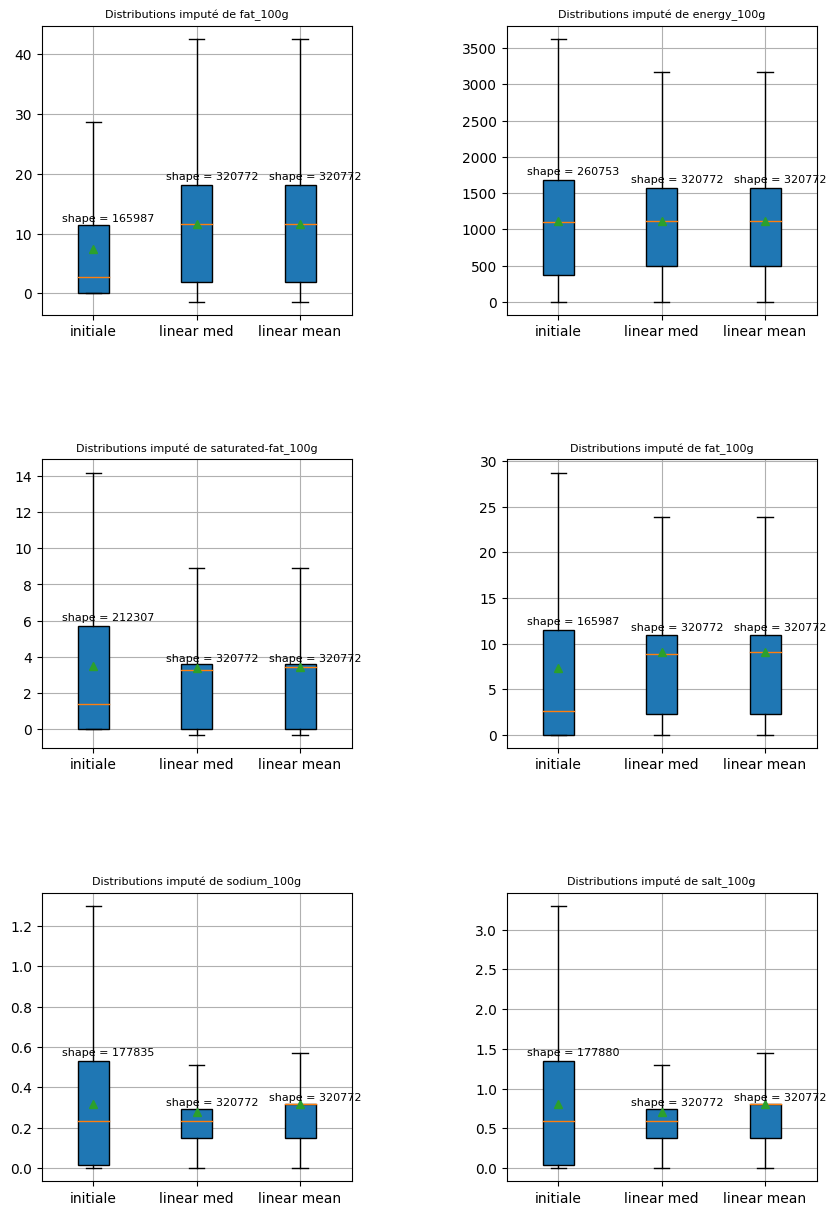

In [ ]:
LinearImputerCouple(Listed_couple_corr)

L'imputation par défaut par la médian change un peu moins la distribution que par la moyenne. C'est donc la médiane que nous retiendrons.

In [ ]:
imputer_linear=IterativeImputer(estimator=BayesianRidge(),initial_strategy='median')

for couple_id in range(len(Listed_couple_corr)):

  tabl_imp=imputer_linear.fit_transform(df_work[Listed_couple_corr[couple_id]])
  df_work[Listed_couple_corr[couple_id]]=pd.DataFrame(tabl_imp)

In [ ]:
Listed_couple_corr

[['fat_100g', 'energy_100g'],
 ['saturated-fat_100g', 'fat_100g'],
 ['sodium_100g', 'salt_100g']]

Les colonnes ont bien été rempli :

In [ ]:
df_work[['fat_100g', 'energy_100g',
 'saturated-fat_100g', 'fat_100g',
 'sodium_100g', 'salt_100g']].describe()

fat_100g    energy_100g  saturated-fat_100g       fat_100g  \
count  320772.000000  320772.000000       320772.000000  320772.000000   
mean       11.667453    1120.327818            3.565024      11.667453   
std         9.697792     715.778375            4.023689       9.697792   
min        -1.430936       0.000000           -0.493585      -1.430936   
25%         1.900000     498.000000            0.000000       1.900000   
50%        11.588833    1113.603351            3.330000      11.588833   
75%        18.140749    1569.000000            5.000000      18.140749   
max        42.646275    3770.000000           17.840000      42.646275   

         sodium_100g      salt_100g  
count  320772.000000  320772.000000  
mean        0.280023       0.711259  
std         0.254459       0.646328  
min         0.000000       0.000000  
25%         0.150000       0.381000  
50%         0.232938       0.591662  
75%         0.294000       0.746760  
max         1.465000       3.721100

### Estimateur KNN et Random forest pour les autres

On reconstruit la liste des variables nutritives après les imputations et nettoyages appliqués.

Afin de ne pas avoir à relancer tout le notebook à chaque fois, j'exporte mon travail en csv pour n'avoir qu'à le réimporter ici et repartir d'où j'étais.

In [ ]:
# ligne pour l'export en CSV
prompt=input('Exporter le csv df_work ? : - yes or -no')
if prompt=='yes':
  print('exportation...')
  df_work.to_csv('/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 3/df_work_copie.csv', index=False)

Exporter le csv df_work ? : - yes or -nono


In [6]:
# import :
df_work=pd.read_csv('/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 3/df_work.csv')
df_work=df_work.drop('Unnamed: 0',axis=1)

<ipython-input-6-27bbfca7bde3>:2: DtypeWarning: Columns (1,4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_work=pd.read_csv('/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 3/df_work.csv')


In [ ]:
# créer une liste qui extrait uniquement les variables nutritionnelles
list_nutri=df_work.loc[:,df_work.columns.str.endswith('100g')].columns.tolist()[:-2] # ne prend pas les nutri-scores
list_nutri

['energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'trans-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

In [ ]:
df_work[list_nutri].isna().mean().sort_values()

energy_100g           0.000000
fat_100g              0.000000
saturated-fat_100g    0.000000
salt_100g             0.000000
sodium_100g           0.000000
proteins_100g         0.415242
sugars_100g           0.483789
carbohydrates_100g    0.489940
trans-fat_100g        0.562627
fiber_100g            0.572977
dtype: float64

<Axes: >

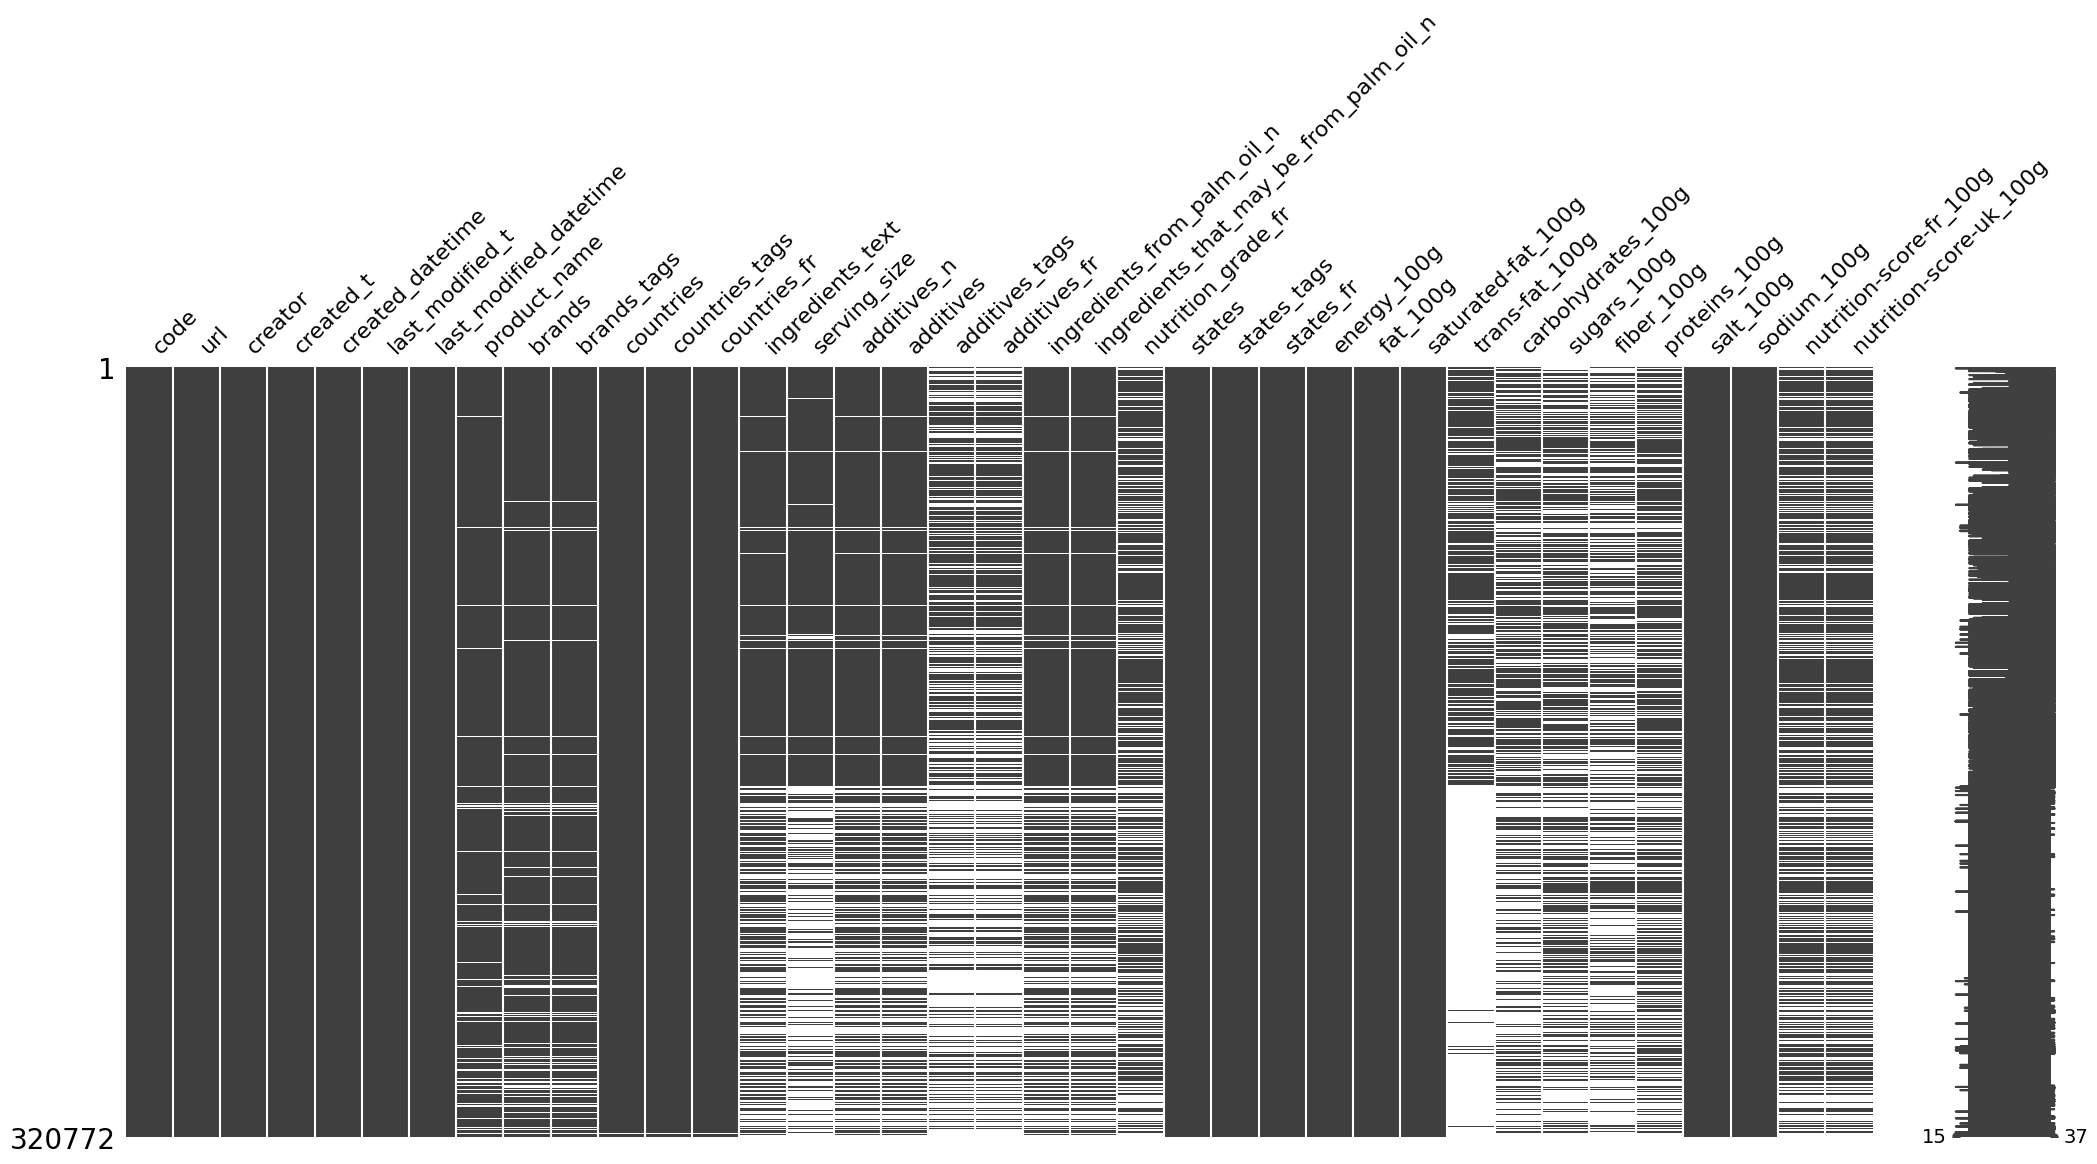

In [7]:
import missingno as msno
msno.matrix(df_work)

In [ ]:
# fonction qui renvoi un dataframe prêt pour imputation : avec à gauche les colonnes
# pleines et à droite la colonne la plus remplie parmi les colonens à remplir
def df_to_impute(df_source):
  """
  df_source : df de base pour les calculs
  """
  df_copie=df_source.copy()
  # serie des taux de NaN des variables du df tri par ordre croissant
  df_info_nan=df_copie.isna().mean().sort_values()
  # liste des variables sans NaN
  list_var_complete=[var for var in df_info_nan.index.tolist() if (df_info_nan[var]==0)]
  # liste des variables avec NaN à imputer
  list_var_to_imp=[var for var in df_info_nan.index.tolist() if (df_info_nan[var]!=0)]
  # création du df à imputer
  if not(list_var_to_imp):#si liste vide car on a tout imputé
    df_to_imp=df_copie[list_var_complete]
  else:
    df_to_imp=df_copie[list_var_complete+[list_var_to_imp[0]]]

  return(df_to_imp)

In [ ]:
# fonction qui renvoie un dataframe de toutes les variable pleines + la variable suivante à imputer
def ImputerLarge(df_to_impute,Imputer=1):
  """
  df_to_impute : df issu de la fonction df_to_impute avec toutes les variables pleines + une variable avec des NaN (la plus remplie)
  Imputer=1 : KNNReg, Imputer=2 : Random Forest
  """

  # initialisation des imputers
  match Imputer:
    case 1:
      imputer_=IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=5))
    case 2:
      imputer_=IterativeImputer(estimator=RandomForestRegressor(n_estimators=15,max_depth=3,
                                                                min_samples_split=150,
                                                                min_samples_leaf=100,
                                                                max_features=2))
  # fit des modeles
  df_=imputer_.fit_transform(df_to_impute)
  # reconstruite les Dataframes
  df_copy_=pd.DataFrame(df_,columns=df_to_impute.columns.tolist())

  return(df_copy_)

Création d'une fonction qui plot les distributions comparées d'une variable entre initiale, après imputation KNN et après imputation Random Forest.

In [ ]:
def Plot_Compare_Estimator(VarToPlot,List_df_,dimX,dimY,position, imputer_est):
  """
  VarToPlot : nom string de la variable à illustrer
  List_df_ : format [df_initial,df_1,df_2,...] : les df dont extraire la variable à illustrer
  dimX,dimY,position : argument de subplot
  imputer_est : liste str du/des type(s) d'estimateur(s)
  """
  # extraction de la variable des trois df en un seul pour le passer en arg du boxplot
  _to_plot=[List_df_[0][VarToPlot].dropna().tolist()]
  for i in range(1,len(List_df_)):
    _to_plot.append(List_df_[i][VarToPlot].tolist())

  _to_plot=np.array(_to_plot)

  # on trace les distribution AVANT vs APRES pour comparaison des estimateurs
  plt.subplot(dimX,dimY,position)
  plt.title(f"Distributions imputé de {VarToPlot}",fontsize=8)
  plt.grid()
  plt.boxplot(_to_plot,vert=True,showmeans=True,showfliers=True,patch_artist = True,labels=['initiale'] + imputer_est)
  plt.gcf().subplots_adjust(hspace = 0.5,wspace = .5)
  for v in range(len(_to_plot)):
    plt.text((v+1)-0.3,np.quantile(_to_plot[v],.75)*1.05,f"shape = {len(_to_plot[v])}",fontsize=8)

La cellule ci-dessous permet de parcourir un dataframe et d'imputer ses colonnes au fur et à mesure par KNN et Random Forest regressors. Chaque nouvelle colonne imputée s'ajoute aux colonnes de références à l'estimateur afin de remplir la colonne suivante (les colonnes cibles sont parcourues par ordre de valeurs manquantes croissante).

In [ ]:
def choice_imputer(df_ini):
  """
  df_ini des variables numériques à imputer. Doit contenir 1 au plusieurs colonnes complète.
  Se base sur randomforest et KNN regressors
  """

#df_ini=df_work

  list_=df_ini.columns.tolist()

  List_df_=[df_to_impute(df_ini[list_])]
  df_=df_ini[list_]

  interrupt='no'
  # tant qu'il reste des colonnes vides dans df ou qu'il n'y a pas d'interruption on continu imputation
  while List_df_[len(List_df_)-1].iloc[:,-1].isna().mean()>0 and interrupt=='no':

    df_knn=ImputerLarge(List_df_[len(List_df_)-1],Imputer=1)
    df_forest=ImputerLarge(List_df_[len(List_df_)-1],Imputer=2)
    variable=List_df_[len(List_df_)-1].columns.tolist()[-1]
    Plot_Compare_Estimator(variable,[List_df_[len(List_df_)-1],df_knn,df_forest],1,1,1, ['KNN','Random Forest'])
    plt.show()

    interrupt=input('interrompre ? : -yes or -no')

    if interrupt=='no':
      DF=df_[list_].copy()
      impute_choice=input('inputer par KNN(1) ou Random Forest(2) ?')
      match int(impute_choice):
        case 1:
          DF[variable]=df_knn[variable]
        case 2:
          DF[variable]=df_forest[variable]
      df_=DF.copy()
    else:
      break

    List_df_.append(df_to_impute(df_))

  print(f'Execution terminé après imputation de {len(List_df_)} colonnes.')
  return(List_df_[len(List_df_)-1]) # df final complètement imputé


Export du résultat en csv

In [4]:
# import :
df_=pd.read_csv('/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 3/df_.csv')
df_

energy_100g   fat_100g  saturated-fat_100g  trans-fat_100g  \
0       1113.603351  11.588833            3.540663             0.0   
1       2243.000000  24.793251            7.632125             0.0   
2       1941.000000  21.262397            0.000000             0.0   
3       2540.000000  28.265647            5.360000             0.0   
4       1552.000000   1.430000            0.392892             0.0   
...             ...        ...                 ...             ...   
320767  1113.603351  11.588833            3.540663             0.0   
320768     0.000000   0.000000            0.000000             0.0   
320769  1113.603351  11.588833            3.540663             0.0   
320770  1113.603351  11.588833            3.540663             0.0   
320771  2092.000000   0.000000           -0.050202             0.0   

        carbohydrates_100g  sugars_100g  fiber_100g  proteins_100g  salt_100g  \
0                19.592431        0.136         NaN          4.004   0.591662   
1                20.424511        4.284         NaN         15.922   0.591662   
2                19.592431        0.000         NaN          7.492   0.591662   
3                22.209364        3.476         NaN          8.572   0.591662   
4                23.175177        1.586         5.7          8.570   0.591662   
...                    ...          ...         ...            ...        ...   
320767           19.592431        0.136         NaN          4.004   0.591662   
320768            0.000000        0.000         0.0          0.000   0.000000   
320769           19.592431        0.136         NaN          4.004   0.591662   
320770           19.592431        0.136         NaN          4.004   0.591662   
320771            0.000000        0.000         NaN          0.000   0.000000   

        sodium_100g  
0          0.232938  
1          0.232938  
2          0.232938  
3          0.232938  
4          0.232938  
...             ...  
320767     0.232938  
320768     0.000000  
320769     0.232938  
320770     0.232938  
320771     0.000000  

[320772 rows x 10 columns]

In [ ]:
df_imp_=choice_imputer(df_)

In [ ]:
df_imp_

energy_100g   fat_100g  saturated-fat_100g  trans-fat_100g  \
0       1113.603351  11.588833            3.540663             0.0   
1       2243.000000  24.793251            7.632125             0.0   
2       1941.000000  21.262397            0.000000             0.0   
3       2540.000000  28.265647            5.360000             0.0   
4       1552.000000   1.430000            0.392892             0.0   
...             ...        ...                 ...             ...   
320767  1113.603351  11.588833            3.540663             0.0   
320768     0.000000   0.000000            0.000000             0.0   
320769  1113.603351  11.588833            3.540663             0.0   
320770  1113.603351  11.588833            3.540663             0.0   
320771  2092.000000   0.000000           -0.050202             0.0   

        carbohydrates_100g  sugars_100g  fiber_100g  proteins_100g  salt_100g  \
0                19.592431        0.136        0.70          4.004   0.591662   
1                20.424511        4.284        2.16         15.922   0.591662   
2                19.592431        0.000        3.60          7.492   0.591662   
3                22.209364        3.476        2.12          8.572   0.591662   
4                23.175177        1.586        5.70          8.570   0.591662   
...                    ...          ...         ...            ...        ...   
320767           19.592431        0.136        0.70          4.004   0.591662   
320768            0.000000        0.000        0.00          0.000   0.000000   
320769           19.592431        0.136        0.70          4.004   0.591662   
320770           19.592431        0.136        0.70          4.004   0.591662   
320771            0.000000        0.000        0.00          0.000   0.000000   

        sodium_100g  
0          0.232938  
1          0.232938  
2          0.232938  
3          0.232938  
4          0.232938  
...             ...  
320767     0.232938  
320768     0.000000  
320769     0.232938  
320770     0.232938  
320771     0.000000  

[320772 rows x 10 columns]

In [ ]:
# ligne pour l'export en CSV
prompt=input('Exporter le csv df_work ? : - yes or -no')
if prompt=='yes':
  print('exportation...')
  df_imp_.to_csv('/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 3/df_2_full.csv', index=False)

Exporter le csv df_work ? : - yes or -noyes
exportation...


In [5]:
df_imp_=pd.read_csv('/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 3/df_2_full.csv')

In [ ]:
df_imp_

In [6]:
# création df full
df_full=df_imp_.copy()

In [ ]:
df_full.describe()

energy_100g       fat_100g  saturated-fat_100g  trans-fat_100g  \
count  320772.000000  320772.000000       320772.000000        320772.0   
mean     1120.327818      11.667453            3.565024             0.0   
std       715.778375       9.697792            4.023689             0.0   
min         0.000000      -1.430936           -0.493585             0.0   
25%       498.000000       1.900000            0.000000             0.0   
50%      1113.603351      11.588833            3.330000             0.0   
75%      1569.000000      18.140749            5.000000             0.0   
max      3770.000000      42.646275           17.840000             0.0   

       carbohydrates_100g    sugars_100g     fiber_100g  proteins_100g  \
count       320772.000000  320772.000000  320772.000000  320772.000000   
mean            17.924241       4.156799       1.291369       6.327870   
std             12.289978       5.141585       1.409971       5.870444   
min              0.000000       0.000000       0.000000       0.000000   
25%              9.680000       0.136000       0.000000       2.380000   
50%             19.592431       2.200000       0.700000       4.004000   
75%             22.209364       6.280000       1.980000       8.740000   
max             66.070000      23.170000       6.980000      26.000000   

           salt_100g    sodium_100g  
count  320772.000000  320772.000000  
mean        0.711259       0.280023  
std         0.646328       0.254459  
min         0.000000       0.000000  
25%         0.381000       0.150000  
50%         0.591662       0.232938  
75%         0.746760       0.294000  
max         3.721100       1.465000

La variable trans-fat semble ne contenir que des valeurs nulles :

In [ ]:
display(df_bis['trans-fat_100g'].describe(),
        df_full['trans-fat_100g'].describe())

On supprime la variable trans-fat_100g qui est quasi nulle partout afin qu'elle ne perturbe pas les analyses de la suite.

In [ ]:
# suppression de trans-fat_100g
df_full=df_full.drop('trans-fat_100g',axis=1)

In [ ]:
# ligne pour l'export en CSV
prompt=input('Exporter le csv df_work ? : - yes or -no')
if prompt=='yes':
  print('exportation...')
  df_full.to_csv('/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 3/df_full_2.csv', index=False)

Exporter le csv df_work ? : - yes or -noyes
exportation...


In [7]:
df_full=pd.read_csv('/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 3/df_full_2.csv')

On met à jour la liste des variables nutriment :

In [8]:
list_nutri

NameError: ignored

In [ ]:
del list_nutri[3]
list_nutri

['energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

Toutes les variables numériques nutritionnelles sont rempli.

In [ ]:
df_full[list_nutri].isna().mean().sort_values()

energy_100g           0.0
fat_100g              0.0
saturated-fat_100g    0.0
carbohydrates_100g    0.0
sugars_100g           0.0
fiber_100g            0.0
proteins_100g         0.0
salt_100g             0.0
sodium_100g           0.0
dtype: float64

Regardons les quelques autres variables numériques que l'on peut rajouter :

In [ ]:
df_work.dtypes

code                                        object
url                                         object
creator                                     object
created_t                                   object
created_datetime                            object
last_modified_t                             object
last_modified_datetime                      object
product_name                                object
brands                                      object
brands_tags                                 object
countries                                   object
countries_tags                              object
countries_fr                                object
ingredients_text                            object
serving_size                                object
additives_n                                float64
additives                                   object
additives_tags                              object
additives_fr                                object
ingredients_from_palm_oil_n    

In [ ]:
df_work[['additives_n','ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil_n']].isna().mean()

additives_n                                0.223938
ingredients_from_palm_oil_n                0.223938
ingredients_that_may_be_from_palm_oil_n    0.223938
dtype: float64

In [ ]:
df_work[['additives_n','ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil_n']].describe()

additives_n  ingredients_from_palm_oil_n  \
count  248939.000000                248939.000000   
mean        1.936024                     0.019659   
std         2.502019                     0.140524   
min         0.000000                     0.000000   
25%         0.000000                     0.000000   
50%         1.000000                     0.000000   
75%         3.000000                     0.000000   
max        31.000000                     2.000000   

       ingredients_that_may_be_from_palm_oil_n  
count                            248939.000000  
mean                                  0.055246  
std                                   0.269207  
min                                   0.000000  
25%                                   0.000000  
50%                                   0.000000  
75%                                   0.000000  
max                                   6.000000

Vérifions leur distribution :

(array([0, 1, 2]),
 [Text(0, 0, 'additives_n'),
  Text(1, 0, 'ingredients_from_palm_oil_n'),
  Text(2, 0, 'ingredients_that_may_be_from_palm_oil_n')])

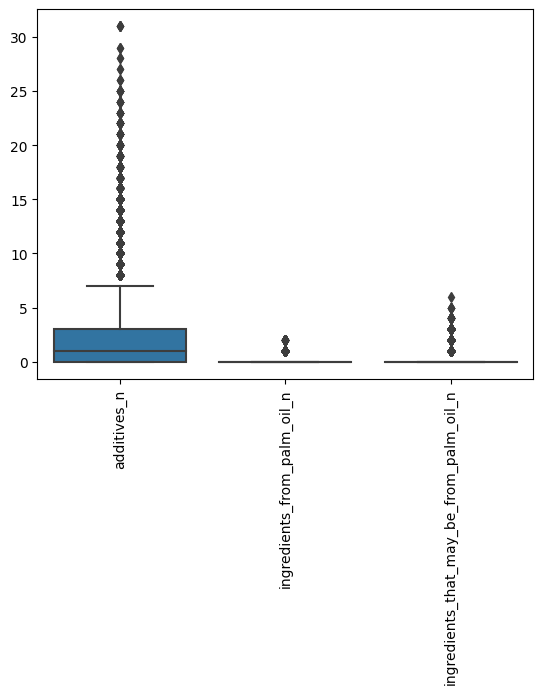

In [ ]:
data=df_work[['additives_n','ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil_n']]
plt.figure()
sns.boxplot(data=data,orient='v')
plt.xticks(rotation=90)

Additive pourrait être intéressant à garder dans l'analyse. Par contre les deux autres variables sont quasiment nulles partout et pourrait perturber les inerties dans ACP.

In [ ]:
df_full.columns

Index(['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g'],
      dtype='object')

Nous mergeons la colonne des additifs et les variables nutritionelles sur la colonne des index, puis nous imputons la colonne additif.

In [ ]:
# création du df additif et nutrition à merger :
df1=df_work['additives_n'].reset_index()
df2=df_full.reset_index()

In [ ]:
# merge des deux sur les index :
df_full=df2.merge(df1, on = ['index'])

In [ ]:
df_full=df_full.drop('index',axis=1)
df_full

energy_100g   fat_100g  saturated-fat_100g  carbohydrates_100g  \
0       1113.603351  11.588833            3.540663           19.592431   
1       2243.000000  24.793251            7.632125           20.424511   
2       1941.000000  21.262397            0.000000           19.592431   
3       2540.000000  28.265647            5.360000           22.209364   
4       1552.000000   1.430000            0.392892           23.175177   
...             ...        ...                 ...                 ...   
320767  1113.603351  11.588833            3.540663           19.592431   
320768     0.000000   0.000000            0.000000            0.000000   
320769  1113.603351  11.588833            3.540663           19.592431   
320770  1113.603351  11.588833            3.540663           19.592431   
320771  2092.000000   0.000000           -0.050202            0.000000   

        sugars_100g  fiber_100g  proteins_100g  salt_100g  sodium_100g  \
0             0.136        0.70          4.004   0.591662     0.232938   
1             4.284        2.16         15.922   0.591662     0.232938   
2             0.000        3.60          7.492   0.591662     0.232938   
3             3.476        2.12          8.572   0.591662     0.232938   
4             1.586        5.70          8.570   0.591662     0.232938   
...             ...         ...            ...        ...          ...   
320767        0.136        0.70          4.004   0.591662     0.232938   
320768        0.000        0.00          0.000   0.000000     0.000000   
320769        0.136        0.70          4.004   0.591662     0.232938   
320770        0.136        0.70          4.004   0.591662     0.232938   
320771        0.000        0.00          0.000   0.000000     0.000000   

        additives_n  
0               NaN  
1               0.0  
2               0.0  
3               0.0  
4               0.0  
...             ...  
320767          NaN  
320768          0.0  
320769          NaN  
320770          NaN  
320771          7.0  

[320772 rows x 10 columns]

<ipython-input-13-e5c70b1e32eb>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _to_plot=np.array(_to_plot)


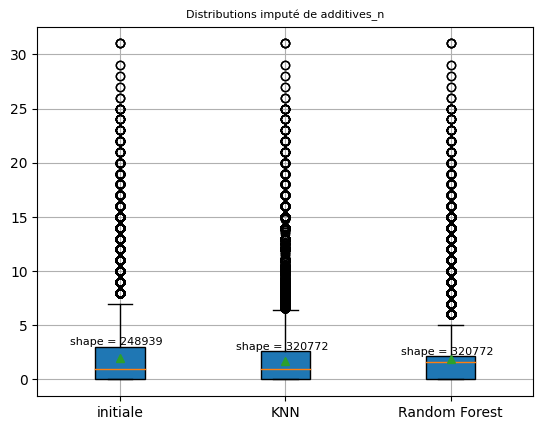

interrompre ? : -yes or -nono
inputer par KNN(1) ou Random Forest(2) ?1
Execution terminé après imputation de 2 colonnes.


In [ ]:
# imputation des additifs :
df_=choice_imputer(df_full)

In [ ]:
df_full=df_.copy()

In [ ]:
# ligne pour l'export en CSV
prompt=input('Exporter le csv df_work ? : - yes or -no')
if prompt=='yes':
  print('exportation...')
  df_full.to_csv('/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 3/df_full_3.csv', index=False)

Exporter le csv df_work ? : - yes or -noyes
exportation...


In [9]:
# import
df_full=pd.read_csv('/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 3/df_full_3.csv')

In [ ]:
df_full

energy_100g   fat_100g  saturated-fat_100g  carbohydrates_100g  \
0       1113.603351  11.588833            3.540663           19.592431   
1       2243.000000  24.793251            7.632125           20.424511   
2       1941.000000  21.262397            0.000000           19.592431   
3       2540.000000  28.265647            5.360000           22.209364   
4       1552.000000   1.430000            0.392892           23.175177   
...             ...        ...                 ...                 ...   
320767  1113.603351  11.588833            3.540663           19.592431   
320768     0.000000   0.000000            0.000000            0.000000   
320769  1113.603351  11.588833            3.540663           19.592431   
320770  1113.603351  11.588833            3.540663           19.592431   
320771  2092.000000   0.000000           -0.050202            0.000000   

        sugars_100g  fiber_100g  proteins_100g  salt_100g  sodium_100g  \
0             0.136        0.70          4.004   0.591662     0.232938   
1             4.284        2.16         15.922   0.591662     0.232938   
2             0.000        3.60          7.492   0.591662     0.232938   
3             3.476        2.12          8.572   0.591662     0.232938   
4             1.586        5.70          8.570   0.591662     0.232938   
...             ...         ...            ...        ...          ...   
320767        0.136        0.70          4.004   0.591662     0.232938   
320768        0.000        0.00          0.000   0.000000     0.000000   
320769        0.136        0.70          4.004   0.591662     0.232938   
320770        0.136        0.70          4.004   0.591662     0.232938   
320771        0.000        0.00          0.000   0.000000     0.000000   

        additives_n  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  
...             ...  
320767          0.0  
320768          0.0  
320769          0.0  
320770          0.0  
320771          7.0  

[320772 rows x 10 columns]

La distribution de additive_n est assez fidèle à la distribution d'origine après imputation par KNN Regressor :

In [ ]:
display(df_work['additives_n'].describe(),df_full['additives_n'].describe())

count    248939.000000
mean          1.936024
std           2.502019
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          31.000000
Name: additives_n, dtype: float64

count    320772.000000
mean          1.679341
std           2.357746
min           0.000000
25%           0.000000
50%           1.000000
75%           2.600000
max          31.000000
Name: additives_n, dtype: float64

## REMPLISSAGE DES NUTRI-SCORE

#### BREVE EXPLORATION DES VALEURS

On commence par rajouter les colonnes des nutri-scores.

In [13]:
df_work.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'ph_100g', 'fruits-vegetables-nuts_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=162)

In [14]:
nutri_list=['nutrition_grade_fr','nutrition-score-fr_100g','nutrition-score-uk_100g']
df_work.loc[df_work['nutrition_grade_fr'].isna()==False,nutri_list]

nutrition_grade_fr  nutrition-score-fr_100g  nutrition-score-uk_100g
1                       d                     14.0                     14.0
2                       b                      0.0                      0.0
3                       d                     12.0                     12.0
7                       c                      7.0                      7.0
12                      d                     12.0                     12.0
...                   ...                      ...                      ...
320742                  a                     -1.0                     -1.0
320751                  a                     -4.0                     -4.0
320757                  b                      0.0                      0.0
320763                  c                      2.0                      0.0
320768                  b                      0.0                      0.0

[221210 rows x 3 columns]

In [ ]:
df_work[nutri_list].isna().mean()

nutrition_grade_fr         0.310382
nutrition-score-fr_100g    0.310382
nutrition-score-uk_100g    0.310382
dtype: float64

Les remplissage de ces colonnes est totalement corrélés.

<Axes: >

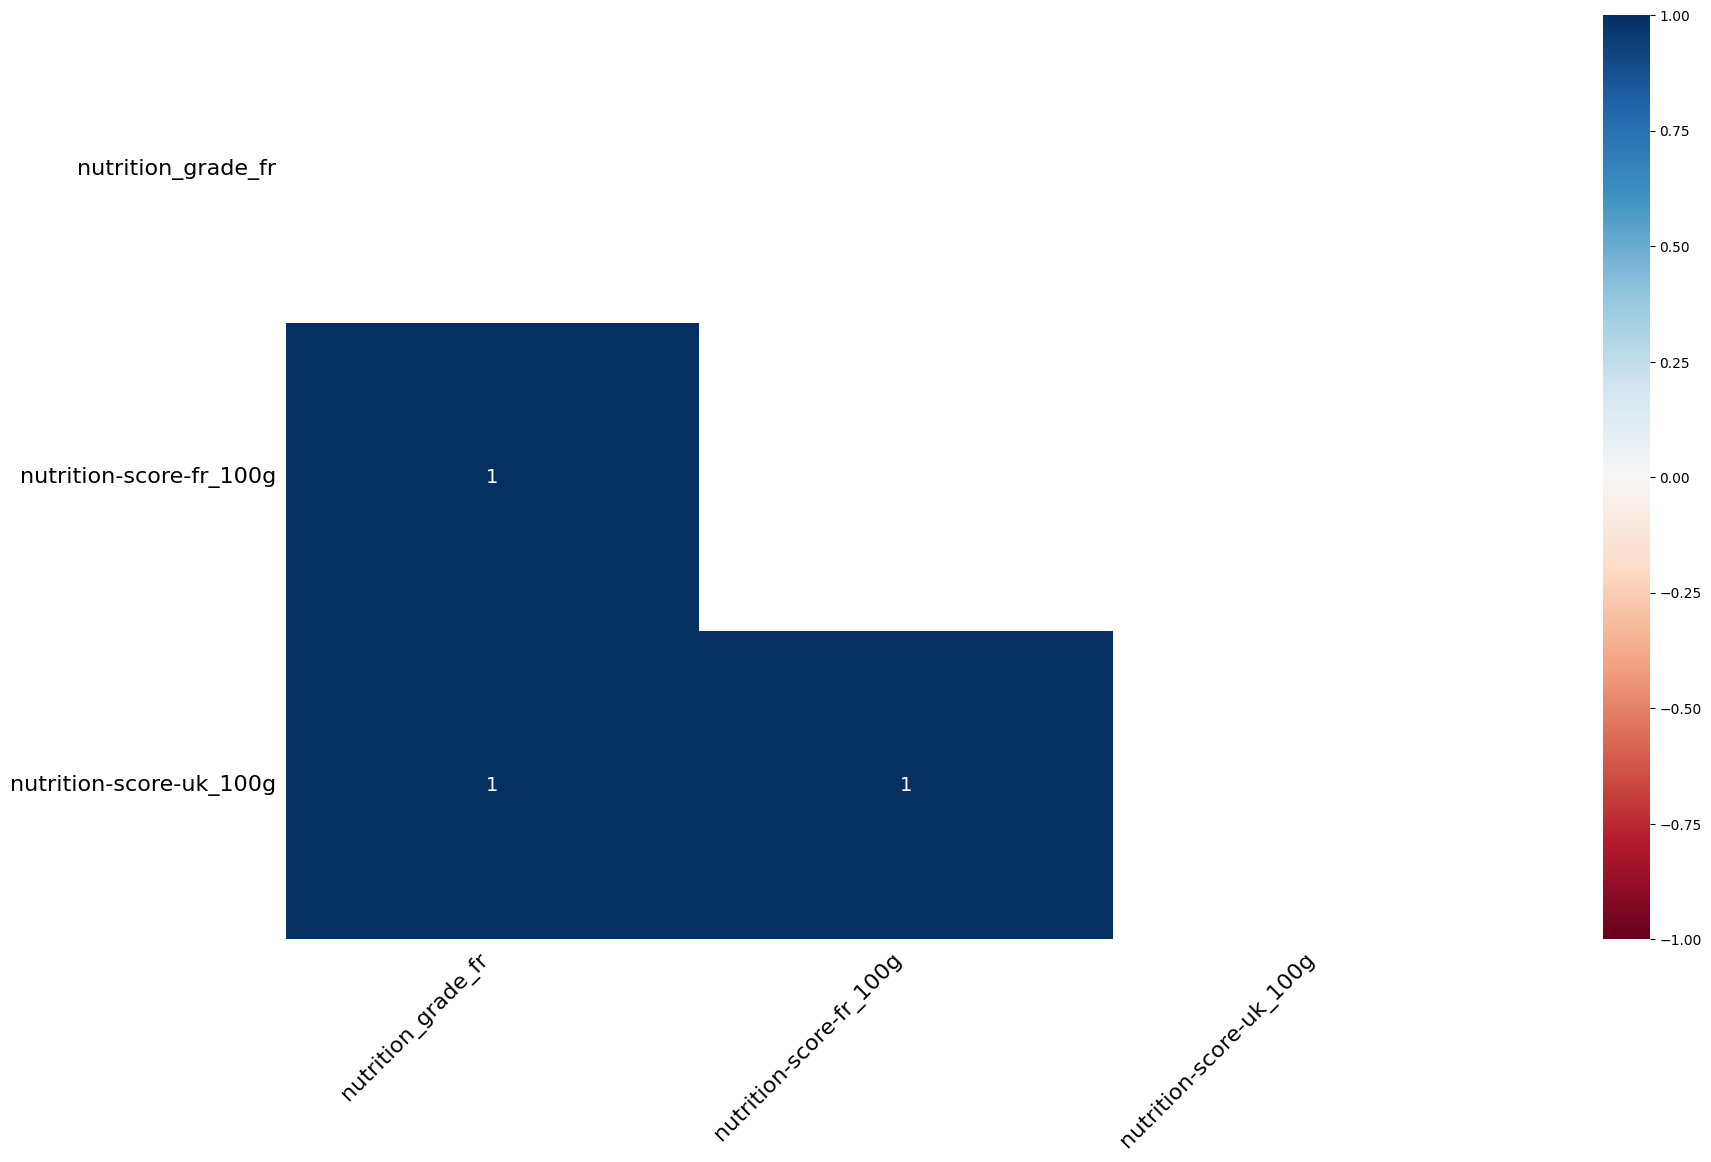

In [ ]:
msno.heatmap(df_work[nutri_list])

Cependant une petite partie des nutri-scores renseignés sont différents :

In [15]:
DF=df_work.loc[df_work['nutrition_grade_fr'].isna()==False,nutri_list]
df_diff_nutri=DF.loc[DF['nutrition-score-fr_100g']!=DF['nutrition-score-uk_100g'],
 :]

In [16]:
pop_nutri=df_work['nutrition-score-fr_100g'].count()
print(f'{round((df_diff_nutri.shape[0])/(pop_nutri),2)} % des nutri-score valorisés sont différents')

0.04 % des nutri-score valorisés sont différents


Voyons la moyenne des nutri-scores par nutrition-grade :

In [ ]:
DF.groupby('nutrition_grade_fr')[nutri_list].mean()

<ipython-input-11-90f5aa78734d>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DF.groupby('nutrition_grade_fr')[nutri_list].mean()


nutrition-score-fr_100g  nutrition-score-uk_100g
nutrition_grade_fr                                                  
a                                 -3.407644                -3.409132
b                                  0.906673                 0.885151
c                                  6.367561                 6.222539
d                                 14.066934                14.181381
e                                 21.962305                21.414641

Nous allons supprimer les valeurs différentes entre les deux nutri-score des données :

In [ ]:
mask=~(DF['nutrition-score-fr_100g']!=DF['nutrition-score-uk_100g'])
df_knn_nutri=DF.loc[mask,:]

NameError: ignored

Je fais l'hypothèse que les nutriscore sont cohérents avec les produit dans les données de base malgrès les valeurs abérrantes initialement présentes qui ont été supprimées dans le processus de nettoyage.

Nous allons entraîner et optimiser un KNN Regressor pour prédire les nutri-score puis imputer les valeurs manquantes avec le modèle obtenu.

### PREDICTION DU NUTRI-SCORE

#### Préparation du dataset

KNeighborsRegressor(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

Dans ce travail nous allons uniquement jouer sur n_neighbors.

A part une petite proportion des deux nutri-scores, tous sont égaux. Nous n'en garderons qu'une seule.

In [ ]:
df1=df_work['nutrition-score-fr_100g'].reset_index()
df2=df_full.reset_index()
df_full=df2.merge(df1, on = ['index'])
df_full

index  energy_100g   fat_100g  saturated-fat_100g  \
0            0  1113.603351  11.588833            3.540663   
1            1  2243.000000  24.793251            7.632125   
2            2  1941.000000  21.262397            0.000000   
3            3  2540.000000  28.265647            5.360000   
4            4  1552.000000   1.430000            0.392892   
...        ...          ...        ...                 ...   
320767  320767  1113.603351  11.588833            3.540663   
320768  320768     0.000000   0.000000            0.000000   
320769  320769  1113.603351  11.588833            3.540663   
320770  320770  1113.603351  11.588833            3.540663   
320771  320771  2092.000000   0.000000           -0.050202   

        carbohydrates_100g  sugars_100g  fiber_100g  proteins_100g  salt_100g  \
0                19.592431        0.136        0.70          4.004   0.591662   
1                20.424511        4.284        2.16         15.922   0.591662   
2                19.592431        0.000        3.60          7.492   0.591662   
3                22.209364        3.476        2.12          8.572   0.591662   
4                23.175177        1.586        5.70          8.570   0.591662   
...                    ...          ...         ...            ...        ...   
320767           19.592431        0.136        0.70          4.004   0.591662   
320768            0.000000        0.000        0.00          0.000   0.000000   
320769           19.592431        0.136        0.70          4.004   0.591662   
320770           19.592431        0.136        0.70          4.004   0.591662   
320771            0.000000        0.000        0.00          0.000   0.000000   

        sodium_100g  additives_n  nutrition-score-fr_100g  
0          0.232938          0.0                      NaN  
1          0.232938          0.0                     14.0  
2          0.232938          0.0                      0.0  
3          0.232938          0.0                     12.0  
4          0.232938          0.0                      NaN  
...             ...          ...                      ...  
320767     0.232938          0.0                      NaN  
320768     0.000000          0.0                      0.0  
320769     0.232938          0.0                      NaN  
320770     0.232938          0.0                      NaN  
320771     0.000000          7.0                      NaN  

[320772 rows x 12 columns]

On supprime la colonne des index temporaire.

In [ ]:
df_full=df_full.drop('index',axis=1)
df_full.head()

energy_100g   fat_100g  saturated-fat_100g  carbohydrates_100g  \
0  1113.603351  11.588833            3.540663           19.592431   
1  2243.000000  24.793251            7.632125           20.424511   
2  1941.000000  21.262397            0.000000           19.592431   
3  2540.000000  28.265647            5.360000           22.209364   
4  1552.000000   1.430000            0.392892           23.175177   

   sugars_100g  fiber_100g  proteins_100g  salt_100g  sodium_100g  \
0        0.136        0.70          4.004   0.591662     0.232938   
1        4.284        2.16         15.922   0.591662     0.232938   
2        0.000        3.60          7.492   0.591662     0.232938   
3        3.476        2.12          8.572   0.591662     0.232938   
4        1.586        5.70          8.570   0.591662     0.232938   

   additives_n  nutrition-score-fr_100g  
0          0.0                      NaN  
1          0.0                     14.0  
2          0.0                      0.0  
3          0.0                     12.0  
4          0.0                      NaN

#### Préparation du modèle

Séparons les données d'entrée de la cible.

In [ ]:
# entrées
X=df_full.dropna().iloc[:,:-1]
# cible
y=df_full.dropna().iloc[:,-1]

In [ ]:
display(X,y)

energy_100g   fat_100g  saturated-fat_100g  carbohydrates_100g  \
1            2243.0  24.793251            7.632125           20.424511   
2            1941.0  21.262397            0.000000           19.592431   
3            2540.0  28.265647            5.360000           22.209364   
7            1833.0  19.999708            4.690000           22.209364   
12           2230.0  36.670000            5.000000           36.670000   
...             ...        ...                 ...                 ...   
320742       1477.0   0.000000            0.000000           19.787926   
320751       1643.0   2.800000            0.600000           26.087473   
320757       2406.0  26.698976            3.730000           19.301927   
320763         21.0   0.200000            0.200000            0.500000   
320768          0.0   0.000000            0.000000            0.000000   

        sugars_100g  fiber_100g  proteins_100g  salt_100g  sodium_100g  \
1             4.284       2.160         15.922   0.591662     0.232938   
2             0.000       3.600          7.492   0.591662     0.232938   
3             3.476       2.120          8.572   0.591662     0.232938   
7            10.760       2.964          9.980   0.591662     0.232938   
12            3.330       6.700         16.670   1.607820     0.633000   
...             ...         ...            ...        ...          ...   
320742        2.350       4.700          1.180   0.030480     0.012000   
320751        2.600       5.900         13.000   0.680000     0.267717   
320757        3.890       5.220         21.220   0.100000     0.039370   
320763        0.500       0.200          0.500   0.025400     0.010000   
320768        0.000       0.000          0.000   0.000000     0.000000   

        additives_n  
1               0.0  
2               0.0  
3               0.0  
7               2.0  
12              1.0  
...             ...  
320742          0.0  
320751          0.4  
320757          0.0  
320763          0.0  
320768          0.0  

[221210 rows x 10 columns]

1         14.0
2          0.0
3         12.0
7          7.0
12        12.0
          ... 
320742    -1.0
320751    -4.0
320757     0.0
320763     2.0
320768     0.0
Name: nutrition-score-fr_100g, Length: 221210, dtype: float64

Importons les méthode d'entraînement et de scoring :

Rappel pour train test split :

 sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)[source]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# Séparation entraînement et test :
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Le nombre de voisins de 1550 est optimal avec un score de 5.675397299603372.


Text(0.5, 1.0, 'Courbe du score en fonction de n_neighbors')

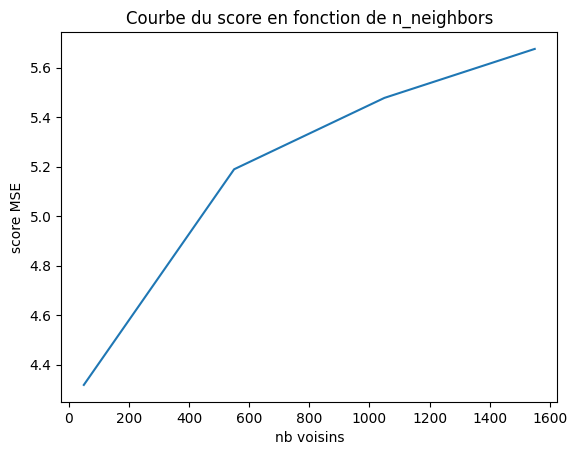

In [ ]:
# recherche du nombre de voisin otpimal :
n_,score_=[],[]
for n in range(50,2000,500):
  imputer_ = KNeighborsRegressor(n_neighbors=n, weights='uniform', algorithm='auto', leaf_size=30,
                    p=2, metric='minkowski', metric_params=None, n_jobs=None)
  imputer_.fit(X_train,y_train)
  y_pred=imputer_.predict(X_test)
  score=np.sqrt(mean_squared_error(y_test,y_pred))

  n_.append(n)
  score_.append(score)

best_score=np.max(score_)
best_n_=n_[score_.index(best_score)]
print(f'Le nombre de voisins de {best_n_} est optimal avec un score de {best_score}.')

sns.lineplot(x=n_,y=score_)
plt.xlabel('nb voisins')
plt.ylabel('score MSE')
plt.title('Courbe du score en fonction de n_neighbors')

Nous utiliserons n_neigboor = 1550 pour imputer le nutri-score et le nutrition-grade.

Les temps de calculs sont très long pour aller au delà et le score est déjà pas mal à ce niveau.

#### Imputation des nutri-*score*

In [4]:
df_full.head()

energy_100g   fat_100g  saturated-fat_100g  carbohydrates_100g  \
0  1113.603351  11.588833            3.540663           19.592431   
1  2243.000000  24.793251            7.632125           20.424511   
2  1941.000000  21.262397            0.000000           19.592431   
3  2540.000000  28.265647            5.360000           22.209364   
4  1552.000000   1.430000            0.392892           23.175177   

   sugars_100g  fiber_100g  proteins_100g  salt_100g  sodium_100g  \
0        0.136        0.70          4.004   0.591662     0.232938   
1        4.284        2.16         15.922   0.591662     0.232938   
2        0.000        3.60          7.492   0.591662     0.232938   
3        3.476        2.12          8.572   0.591662     0.232938   
4        1.586        5.70          8.570   0.591662     0.232938   

   additives_n  nutrition-score-fr_100g  
0          0.0                10.965161  
1          0.0                14.000000  
2          0.0                 0.000000  
3          0.0                12.000000  
4          0.0                 1.574839

In [ ]:
imputer_KNN_nutri=IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=1550))
df_array=imputer_KNN_nutri.fit_transform(df_full)

In [ ]:
# reconstruite les Dataframes
df_full=pd.DataFrame(df_array,columns=df_full.columns.tolist())

In [ ]:
# ligne pour l'export en CSV
prompt=input('Exporter le csv df_work ? : - yes or -no')
if prompt=='yes':
  print('exportation...')
  df_full.to_csv('/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 3/df_full_wth_nutri_score.csv', index=False)

Exporter le csv df_work ? : - yes or -noyes
exportation...


In [ ]:
df_full=pd.read_csv('/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 3/df_full_wth_nutri_score.csv')

In [ ]:
df_full.describe()

energy_100g       fat_100g  saturated-fat_100g  carbohydrates_100g  \
count  320772.000000  320772.000000       320772.000000       320772.000000   
mean     1120.327818      11.667453            3.565024           17.924241   
std       715.778375       9.697792            4.023689           12.289978   
min         0.000000      -1.430936           -0.493585            0.000000   
25%       498.000000       1.900000            0.000000            9.680000   
50%      1113.603351      11.588833            3.330000           19.592431   
75%      1569.000000      18.140749            5.000000           22.209364   
max      3770.000000      42.646275           17.840000           66.070000   

         sugars_100g     fiber_100g  proteins_100g      salt_100g  \
count  320772.000000  320772.000000  320772.000000  320772.000000   
mean        4.156799       1.291369       6.327870       0.711259   
std         5.141585       1.409971       5.870444       0.646328   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.136000       0.000000       2.380000       0.381000   
50%         2.200000       0.700000       4.004000       0.591662   
75%         6.280000       1.980000       8.740000       0.746760   
max        23.170000       6.980000      26.000000       3.721100   

         sodium_100g    additives_n  nutrition-score-fr_100g  
count  320772.000000  320772.000000            320772.000000  
mean        0.280023       1.679341                 9.188577  
std         0.254459       2.357746                 7.894615  
min         0.000000       0.000000               -15.000000  
25%         0.150000       0.000000                 2.501290  
50%         0.232938       1.000000                10.965161  
75%         0.294000       2.600000                14.000000  
max         1.465000      31.000000                40.000000

<ipython-input-107-e31ab3a77f2d>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.boxplot(np.array([df_work['nutrition-score-fr_100g'].dropna(),df_full['nutrition-score-fr_100g'].dropna()]),


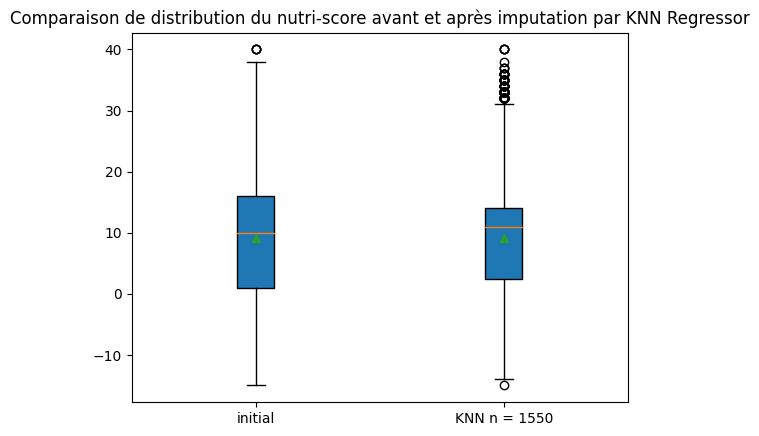

In [ ]:
plt.boxplot(np.array([df_work['nutrition-score-fr_100g'].dropna(),df_full['nutrition-score-fr_100g'].dropna()]),
            vert=True, showmeans=True,labels=['initial','KNN n = 1550'],patch_artist=True)
plt.title('Comparaison de distribution du nutri-score avant et après imputation par KNN Regressor')
plt.show()

#### Prédiction du nutrition-grade

La cellule suivante me permet de gagner du temps dans pour réimporter les packages nécessaires et les traitements fait sur les données :

In [2]:
# A lancer pour reprendre rapidement

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

# import :
df_work=pd.read_csv('/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 3/df_work.csv')
df_work=df_work.drop('Unnamed: 0',axis=1)


nutri_list=['nutrition_grade_fr','nutrition-score-fr_100g','nutrition-score-uk_100g']
DF=df_work.loc[df_work['nutrition_grade_fr'].isna()==False,nutri_list]
df_diff_nutri=DF.loc[DF['nutrition-score-fr_100g']!=DF['nutrition-score-uk_100g'],
 :]
mask=~(DF['nutrition-score-fr_100g']!=DF['nutrition-score-uk_100g'])
df_knn_nutri=DF.loc[mask,:]

# comme iterative imputer est encore experimentale (le code evolue encore selon les versions) il faut d'abord importer le module expérimentale ci-dessous
from sklearn.experimental import enable_iterative_imputer
# avant d'importer Iterative Imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import LinearRegression,BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

df_full=pd.read_csv('/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 3/df_full_wth_nutri_score.csv')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-2-0a5128b883d1>:11: DtypeWarning: Columns (1,4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_work=pd.read_csv('/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 3/df_work.csv')


Nota : le nutrition grade est attribué en fonction de la valeur numérique de nutri-score mais également en fonction du type d'aliment selon qu'il soit une boisson, un aliment gras ou un aliment solide. Or ces catégories ont été supprimées lors de l'étape de nettoyage. Nous allons donc passer par du machine learning pour compléter cette colonne.

Il nous faut importer les deux packages suivants et numériser la variable nutrition-grade pour entraîner le modèle :

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [26]:
# numérisation de cible
def numeric_nutri_grade(y_grd_str):
  """y_grd_str is the str np.array column to numerise"""
  L=[]
  for i in y_grd_str:
    match str(i):
      case 'a':
        L.append(1)
      case 'b':
        L.append(2)
      case 'c':
        L.append(3)
      case 'd':
        L.append(4)
      case 'e':
        L.append(5)

  return(np.array(L))

In [27]:
# entrées
X_grd=df_knn_nutri.dropna().loc[:,['nutrition-score-fr_100g','nutrition-score-uk_100g']]
# cible
y_grd_str=np.array(df_knn_nutri.dropna().loc[:,'nutrition_grade_fr'])
# numérisation de cible
y_grd=numeric_nutri_grade(y_grd_str)

display(X_grd,y_grd,y_grd_str)

nutrition-score-fr_100g  nutrition-score-uk_100g
1                          14.0                     14.0
2                           0.0                      0.0
3                          12.0                     12.0
7                           7.0                      7.0
12                         12.0                     12.0
...                         ...                      ...
320741                      0.0                      0.0
320742                     -1.0                     -1.0
320751                     -4.0                     -4.0
320757                      0.0                      0.0
320768                      0.0                      0.0

[212888 rows x 2 columns]

array([4, 2, 4, ..., 1, 2, 2])

array(['d', 'b', 'd', ..., 'a', 'b', 'b'], dtype=object)

Nota : j'ai finalement opté pour une nombre de voisin de 400 au lieu de 1550 comme étudié ci-dessus en raison des temps de calcul, sachant que le score du modèle est tout de même acceptable à partir de 400 voisins.

Je compare les résultats obtenus entre 2 méthodes :

1) la prédiction de la colonne nutrition-grade via un modèle KNN Regressor entraîné sur les colonnes de nutri-score complètes

2) la classification du nutri-grade via la définition des intervalles de nutriscore correspondants que l'on trouve dans la documentation Santé Public France.

Nota : le problème de la seconde méthode est que l'attribution de la lettre dépend de la nature du produit selon qu'il soit un solide, un liquide (boisson) ou un aliment gras d'origine animal. Comme nous ne disposons pas de ces champs permettant d'identifier la nature du produit après le processus de nettoyage des données, j'ai tenté de généraliser ces intervalles (voir ci-dessous).

In [18]:
# Séparation entraînement et test :
X_grd_train, X_grd_test, y_grd_train, y_grd_test = train_test_split(X_grd, y_grd, test_size=0.2, random_state=42)

classifier_=KNeighborsClassifier(n_neighbors=400) # 400 au lieu de 1550 car trop long à exécuter sur 320000 lignes
classifier_.fit(X_grd_train,y_grd_train)
y_grd_pred=classifier_.predict(X_grd_test)
print(f'nutri-grades trouvés avec {accuracy_score(y_grd_test,y_grd_pred)} % de précision.')

nutri-grades trouvés avec 0.999459814927897 % de précision.


Je complète le df_full avec une colonne nutrition-grade calculé avec le modèle.

In [5]:
df_full.head()

energy_100g   fat_100g  saturated-fat_100g  carbohydrates_100g  \
0  1113.603351  11.588833            3.540663           19.592431   
1  2243.000000  24.793251            7.632125           20.424511   
2  1941.000000  21.262397            0.000000           19.592431   
3  2540.000000  28.265647            5.360000           22.209364   
4  1552.000000   1.430000            0.392892           23.175177   

   sugars_100g  fiber_100g  proteins_100g  salt_100g  sodium_100g  \
0        0.136        0.70          4.004   0.591662     0.232938   
1        4.284        2.16         15.922   0.591662     0.232938   
2        0.000        3.60          7.492   0.591662     0.232938   
3        3.476        2.12          8.572   0.591662     0.232938   
4        1.586        5.70          8.570   0.591662     0.232938   

   additives_n  nutrition-score-fr_100g  
0          0.0                10.965161  
1          0.0                14.000000  
2          0.0                 0.000000  
3          0.0                12.000000  
4          0.0                 1.574839

In [46]:
# classification avec les ranges de la définition des nutri-score
def range_def_grade_classifier(nutri_val):
  """ nutri_val is the np.array numeric nutri-score to classify as nutri-grade frome range definition"""
  L=[]
  for y in nutri_val:
    if (y>=-6) & (y<-4):
        L.append(1)
    elif (y>=-4) & (y<2):
        L.append(2)
    elif (y>=3) & (y<6):
        L.append(3)
    elif (y>=7) & (y<9):
        L.append(4)
    else:
        L.append(5)

  return(np.array(L))

In [50]:
# ajout de la colonne nutri uk dans df_full en tant que copie (car les colonnes sont quasiment les mêmes)
df_full['nutrition-score-uk_100g']=df_full['nutrition-score-fr_100g']

# création de la colonne 'nutrition_grade_fr' dans df_full
df_full_copy=df_full.copy()
df_full_copy['nutrition_grade_fr']=classifier_.predict(df_full[['nutrition-score-fr_100g','nutrition-score-uk_100g']])

# extraction des index commun à la colonne initiale
index_ini=df_bis['nutrition_grade_fr'].dropna().index.tolist()
y_pred=np.array(df_full_copy.loc[index_ini,'nutrition_grade_fr'])
y_true=numeric_nutri_grade(np.array(df_bis['nutrition_grade_fr'].dropna()))

# comparaison à une classification via les intervalles de nutri-score que l'on trouve dans la doc santé publique France
y_via_intervalle=range_def_grade_classifier(np.array(df_full_copy.loc[index_ini,'nutrition-score-fr_100g']))

# score avec KNN Classifier
print(f'KNN Classifier : nutri-grades trouvés avec {accuracy_score(y_true,y_pred)} % de précision.')
print(f'intervalles nutr--score def : nutri-grades trouvés avec {accuracy_score(y_true,y_via_intervalle)} % de précision.')

KNN Classifier : nutri-grades trouvés avec 0.9851182134623209 % de précision.
intervalles nutr--score def : nutri-grades trouvés avec 0.43096152976809365 % de précision.


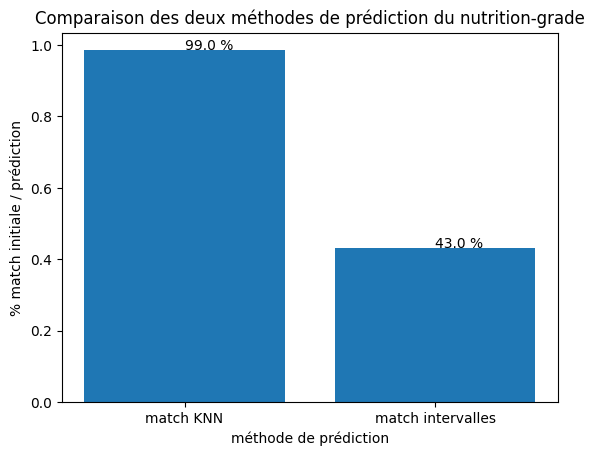

In [58]:
plt.figure()
val_knn,val_interv=accuracy_score(y_true,y_pred),accuracy_score(y_true,y_via_intervalle)
plt.bar(x=["match KNN","match intervalles"],height=[val_knn,val_interv],label=["match KNN","match intervalles"])
plt.xlabel("méthode de prédiction")
plt.ylabel("% match initiale / prédiction")
plt.title("Comparaison des deux méthodes de prédiction du nutrition-grade")
plt.text(x=0,y=val_knn,s=str(round(val_knn,2)*100)+" %")
plt.text(x=1,y=val_interv,s=str(round(val_interv,2)*100)+" %")
plt.show()

On peut s'apercevoir que le modèle KNN est bien plus permformant. C'est cette méthode que l'on retiendra pour la suite étant donné que l'on ne dispose pas des information nécessaires sur la nature des produits.

In [60]:
# création de la colonne 'nutrition_grade_fr' dans df_full
df_full['nutrition_grade_fr']=df_full_copy['nutrition_grade_fr']

In [61]:
df_full.describe()

energy_100g       fat_100g  saturated-fat_100g  carbohydrates_100g  \
count  320772.000000  320772.000000       320772.000000       320772.000000   
mean     1120.327818      11.667453            3.565024           17.924241   
std       715.778375       9.697792            4.023689           12.289978   
min         0.000000      -1.430936           -0.493585            0.000000   
25%       498.000000       1.900000            0.000000            9.680000   
50%      1113.603351      11.588833            3.330000           19.592431   
75%      1569.000000      18.140749            5.000000           22.209364   
max      3770.000000      42.646275           17.840000           66.070000   

         sugars_100g     fiber_100g  proteins_100g      salt_100g  \
count  320772.000000  320772.000000  320772.000000  320772.000000   
mean        4.156799       1.291369       6.327870       0.711259   
std         5.141585       1.409971       5.870444       0.646328   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.136000       0.000000       2.380000       0.381000   
50%         2.200000       0.700000       4.004000       0.591662   
75%         6.280000       1.980000       8.740000       0.746760   
max        23.170000       6.980000      26.000000       3.721100   

         sodium_100g    additives_n  nutrition-score-fr_100g  \
count  320772.000000  320772.000000            320772.000000   
mean        0.280023       1.679341                 9.188577   
std         0.254459       2.357746                 7.894615   
min         0.000000       0.000000               -15.000000   
25%         0.150000       0.000000                 2.501290   
50%         0.232938       1.000000                10.965161   
75%         0.294000       2.600000                14.000000   
max         1.465000      31.000000                40.000000   

       nutrition-score-uk_100g  nutrition_grade_fr  
count            320772.000000       320772.000000  
mean                  9.188577            3.315486  
std                   7.894615            1.197967  
min                 -15.000000            1.000000  
25%                   2.501290            3.000000  
50%                  10.965161            4.000000  
75%                  14.000000            4.000000  
max                  40.000000            5.000000

In [62]:
# ligne pour l'export en CSV
prompt=input('Exporter le csv df_work ? : - yes or -no')
if prompt=='yes':
  print('exportation...')
  df_full.to_csv('/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 3/df_full_wth_nutri_grad.csv', index=False)

Exporter le csv df_work ? : - yes or -noyes
exportation...


In [ ]:
df_full=pd.read_csv('/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 3/df_full_wth_nutri_grad.csv')

### PARENTHESE SUR LE SODIUM

Je viens de me rendre compte que le sodium est très certainement renseigné en mg et non en g. Heureusement dans le dataframe d'origine les lignes ayant une quantité de sodium supérieur à 100 ne sont que 34 ce qui est noyé dans le reste des données, donc mon filtrage au début de ce notebook ayant supprimé les valeurs supérieures à 100 pour cette entrée n'impactera pas vraiment mon analyse.

In [ ]:
df_full['sodium_100g'].describe(),df_bis['sodium_100g'].describe()

(count    320772.000000
 mean          0.280023
 std           0.254459
 min           0.000000
 25%           0.150000
 50%           0.232938
 75%           0.294000
 max           1.465000
 Name: sodium_100g, dtype: float64,
 count    255463.000000
 mean          0.798815
 std          50.504428
 min           0.000000
 25%           0.025000
 50%           0.229000
 75%           0.541000
 max       25320.000000
 Name: sodium_100g, dtype: float64)

In [ ]:
# nombre de lignes ayant un sodium élévé dans le dataframe d'origine
df_bis.loc[df_bis['sodium_100g']>100,'sodium_100g'].count()

34

# EXPLORATION DES DONNEES

## ACP

### Point sur les données et import des packages

Rappel des données traitées :

In [63]:
df_full.describe()

energy_100g       fat_100g  saturated-fat_100g  carbohydrates_100g  \
count  320772.000000  320772.000000       320772.000000       320772.000000   
mean     1120.327818      11.667453            3.565024           17.924241   
std       715.778375       9.697792            4.023689           12.289978   
min         0.000000      -1.430936           -0.493585            0.000000   
25%       498.000000       1.900000            0.000000            9.680000   
50%      1113.603351      11.588833            3.330000           19.592431   
75%      1569.000000      18.140749            5.000000           22.209364   
max      3770.000000      42.646275           17.840000           66.070000   

         sugars_100g     fiber_100g  proteins_100g      salt_100g  \
count  320772.000000  320772.000000  320772.000000  320772.000000   
mean        4.156799       1.291369       6.327870       0.711259   
std         5.141585       1.409971       5.870444       0.646328   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.136000       0.000000       2.380000       0.381000   
50%         2.200000       0.700000       4.004000       0.591662   
75%         6.280000       1.980000       8.740000       0.746760   
max        23.170000       6.980000      26.000000       3.721100   

         sodium_100g    additives_n  nutrition-score-fr_100g  \
count  320772.000000  320772.000000            320772.000000   
mean        0.280023       1.679341                 9.188577   
std         0.254459       2.357746                 7.894615   
min         0.000000       0.000000               -15.000000   
25%         0.150000       0.000000                 2.501290   
50%         0.232938       1.000000                10.965161   
75%         0.294000       2.600000                14.000000   
max         1.465000      31.000000                40.000000   

       nutrition-score-uk_100g  nutrition_grade_fr  
count            320772.000000       320772.000000  
mean                  9.188577            3.315486  
std                   7.894615            1.197967  
min                 -15.000000            1.000000  
25%                   2.501290            3.000000  
50%                  10.965161            4.000000  
75%                  14.000000            4.000000  
max                  40.000000            5.000000

Import des packages nécessaires :

In [64]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import seaborn as sns

In [65]:
sns.set()

préparation des données :

In [66]:
features=['energy_100g','fat_100g','carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','additives_n']

In [67]:
X_data=df_full[features] # tout sauf nutri grade
Y_target=df_full['nutrition_grade_fr'] # juste le nutri grade

### SCALING

Normalisons les données avant de réaliser l'ACP :

In [68]:
scaler = StandardScaler()

In [69]:
X_scaled = scaler.fit_transform(X_data)

les données ont bien été centrées-réduites :

In [70]:
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

0    1    2    3    4    5    6    7
mean  0.0 -0.0 -0.0 -0.0  0.0 -0.0  0.0 -0.0
std   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

### PCA

Voyons les inerties obtenues avec 6 composantes :

In [71]:
n_components = 6

In [72]:
pca = PCA(n_components=n_components)

In [73]:
pca.fit(X_scaled)

PCA(n_components=6)

### EXPLAINED VARIANCE

Examinons les premiers résultats :

In [74]:
pca.explained_variance_ratio_

array([0.29629105, 0.19287546, 0.14119412, 0.12564013, 0.08714444,
       0.08347862])

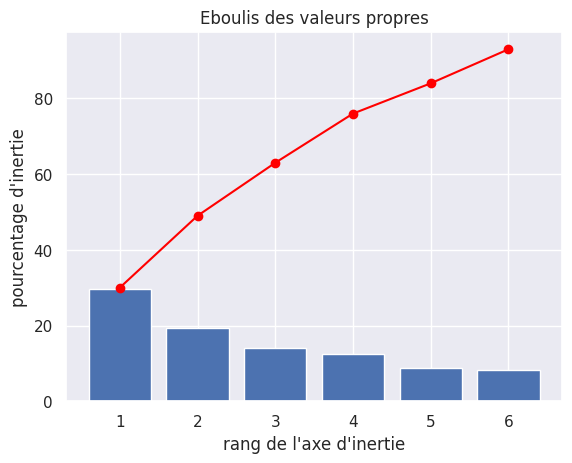

In [75]:
scree = (pca.explained_variance_ratio_*100).round(2)

scree_cum = scree.cumsum().round()

x_list = range(1, n_components+1)
list(x_list)

plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [76]:
display(scree_cum)

array([30., 49., 63., 76., 84., 93.])

Les 4 premiers axes d'inerties permettent d'expliquer 76 % des données.

In [77]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)

pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

energy_100g  fat_100g  carbohydrates_100g  sugars_100g  fiber_100g  \
F1         0.58      0.55                0.24        -0.11        0.26   
F2         0.05     -0.13                0.58         0.56        0.38   
F3        -0.17     -0.05               -0.10         0.19       -0.25   
F4        -0.33     -0.43                0.19        -0.29        0.57   
F5        -0.01     -0.05               -0.31        -0.29        0.33   
F6         0.11      0.01                0.32        -0.67       -0.05   

    proteins_100g  salt_100g  additives_n  
F1           0.40       0.24         0.01  
F2          -0.23      -0.21         0.31  
F3           0.21       0.57         0.70  
F4           0.28       0.38        -0.20  
F5           0.31      -0.58         0.53  
F6          -0.57       0.11         0.31

In [78]:
pcs.T

F1        F2        F3        F4        F5        F6
energy_100g         0.580945  0.052713 -0.165223 -0.329964 -0.011655  0.105697
fat_100g            0.551431 -0.126155 -0.049581 -0.429188 -0.051912  0.013482
carbohydrates_100g  0.238419  0.578166 -0.101879  0.193108 -0.311381  0.315717
sugars_100g        -0.106056  0.558271  0.186737 -0.285125 -0.291630 -0.668166
fiber_100g          0.261569  0.378323 -0.249675  0.569738  0.331806 -0.053115
proteins_100g       0.403743 -0.229294  0.210458  0.279451  0.310469 -0.573726
salt_100g           0.242414 -0.205535  0.574935  0.382064 -0.576467  0.110524
additives_n         0.012005  0.312113  0.698436 -0.199168  0.525702  0.313569

<Axes: >

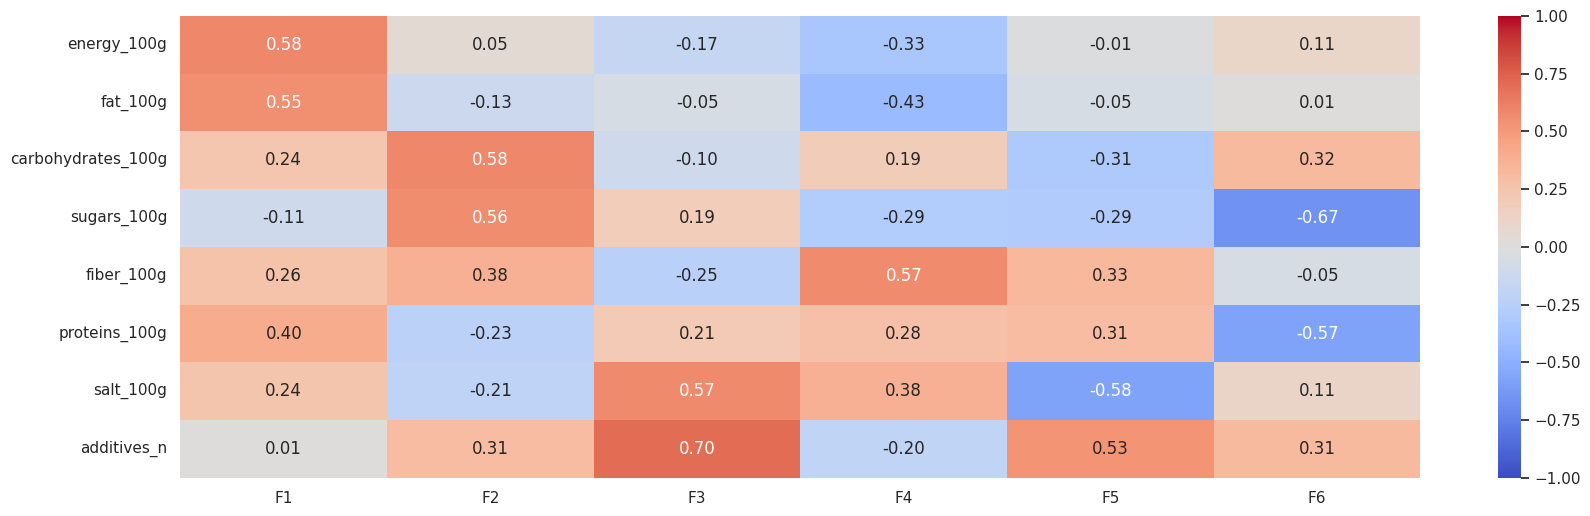

In [79]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

### ILLUSTRATION GRAPHIQUE

Traçons le cercle des corrélations :

In [80]:
def correlation_graph(pca,
                      x_y,
                      features) :
    """Affiche le graphe des correlations

    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] ,
                pca.components_[y, i] ,
                features[i],fontsize=6) #+ 0.05

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

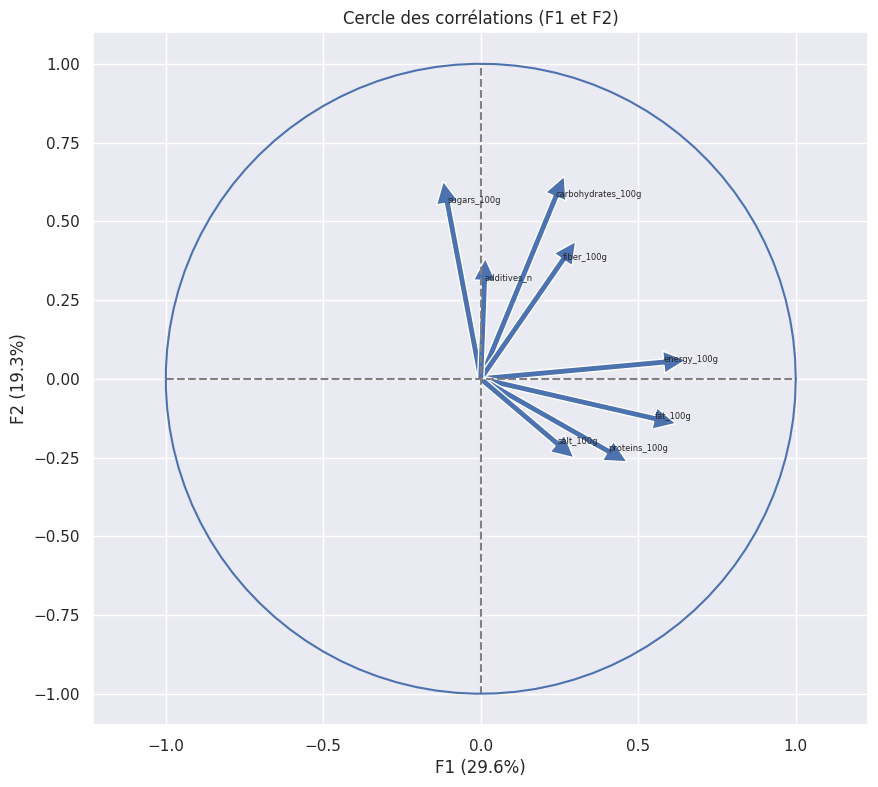

In [82]:
correlation_graph(pca, (0,1), features)

energy_100g et fat_100 sont bien représentés par F1.

carbohydrate_100g et sugar_100g sont bien représenté par F2.

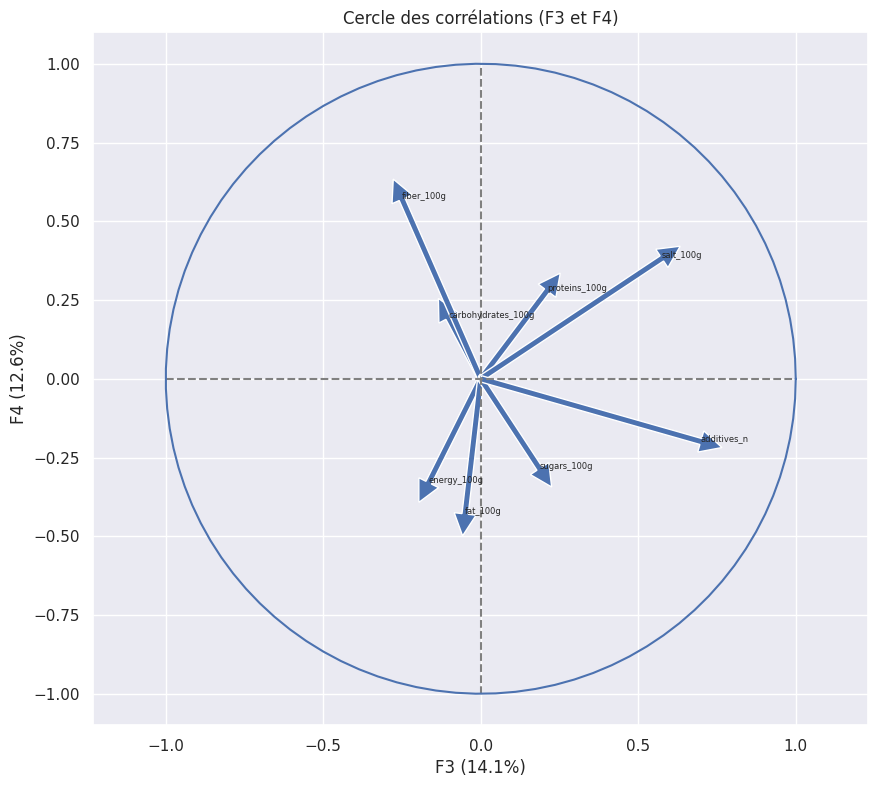

In [83]:
correlation_graph(pca, (2,3), features)

additive_n et salt_100g le mieux représenté par F3.

fiber_100g est le mieux représenté par F4.

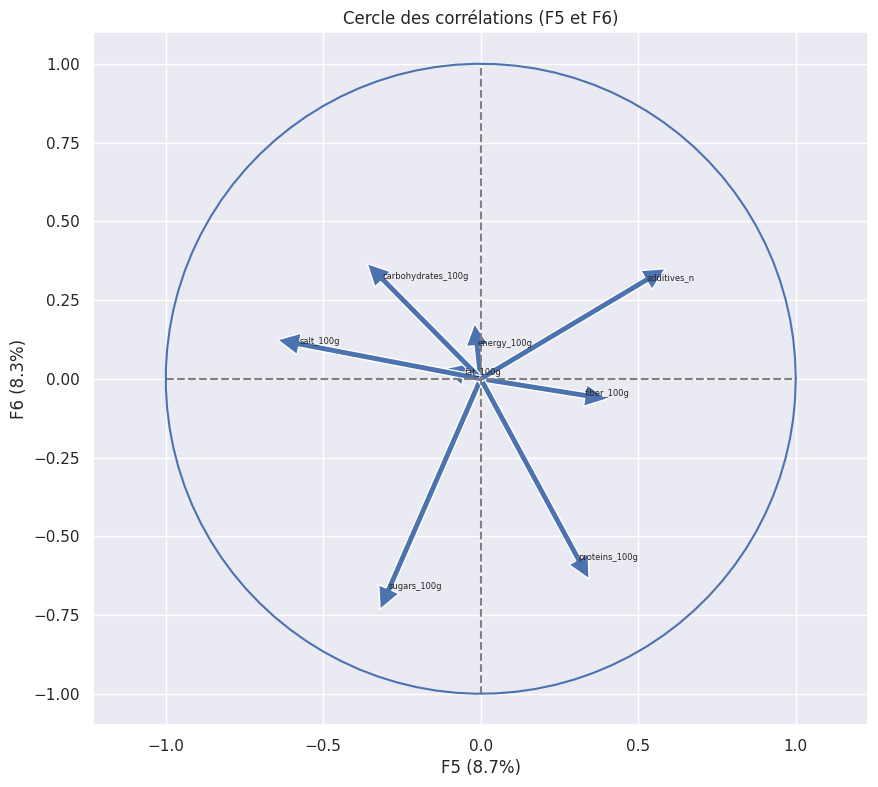

In [84]:
correlation_graph(pca, (4,5), features)

F5 explique négativement le salt_100g et positivement les additive_100g.

F6 explique négativement le sugar_100g et les proteins_100g.

### PROJECTION

Projetons les données scaled sur les axes d'inertie :

In [95]:
X_proj = pca.transform(X_scaled)
X_proj

array([[-0.21756909, -0.60975556, -0.74035895, -0.02265674, -0.34351308,
         0.5698647 ],
       [ 2.47100511, -0.28257877, -0.75608112, -0.18733716,  0.28494277,
        -0.98243685],
       [ 1.78470897, -0.04753787, -1.37422363,  0.51321619,  0.46586877,
         0.27303417],
       ...,
       [-0.21756909, -0.60975556, -0.74035895, -0.02265674, -0.34351308,
         0.5698647 ],
       [-0.21756909, -0.60975556, -0.74035895, -0.02265674, -0.34351308,
         0.5698647 ],
       [-1.05122119, -0.24004856,  0.77823936, -1.67563667,  1.91870316,
         1.46007423]])

In [122]:
X_proj.shape

(320772, 6)

On peut essayer de mettre en évidence les éventuels clusters dans les données afin de mieux illustrer leur cohérence.

In [98]:
from sklearn.cluster import KMeans

In [93]:
# renvoi les indices des classes identifiées par KMeans et les coordonnées des centres des clusters
def Find_and_plot_cluster(X_projeted,n_clusters,x_y):

  x,y=x_y
  X=np.array(X_projeted[:,x:(y+1)])
  kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(X)
  return(kmeans.labels_,kmeans.cluster_centers_)

In [85]:
# affiche la projection sur les axes d'inertie fournis
def display_factorial_planes(   X_projected,
                                x_y,
                                pca=None,
                                labels = None,
                                clusters=None,
                                cluster_coor=None,
                                alpha=1,
                                figsize=[10,8],
                                marker="."):
    """
    Affiche la projection des individus

    Positional arguments :
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments :
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8]
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize:
        figsize = (7,6)

    # On gère les labels
    if  labels is None :
        labels = []
    try :
        len(labels)
    except Exception as e :
        raise e

    # On vérifie la variable axis
    if not len(x_y) ==2 :
        raise AttributeError("2 axes sont demandées")
    if max(x_y )>= X_.shape[1] :
        raise AttributeError("la variable axis n'est pas bonne")

    # on définit x et y
    x, y = x_y

    # Initialisation de la figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters

    # Les points
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha,
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    if cluster_coor.any():
      plt.scatter(x=cluster_coor[:,0],y=cluster_coor[:,1],c='red',marker='X')
      # cercle de rayon 1 autour du centre cluster
      for cl_id in range(cluster_coor[:,0].shape[0]):
        a,b=cluster_coor[cl_id,0],cluster_coor[cl_id,1]
        circle=plt.Circle((a,b),1,color='red',fill=False)
        plt.gca().add_patch(circle)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe
    if pca :
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else :
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) :
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center',color='red')

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()



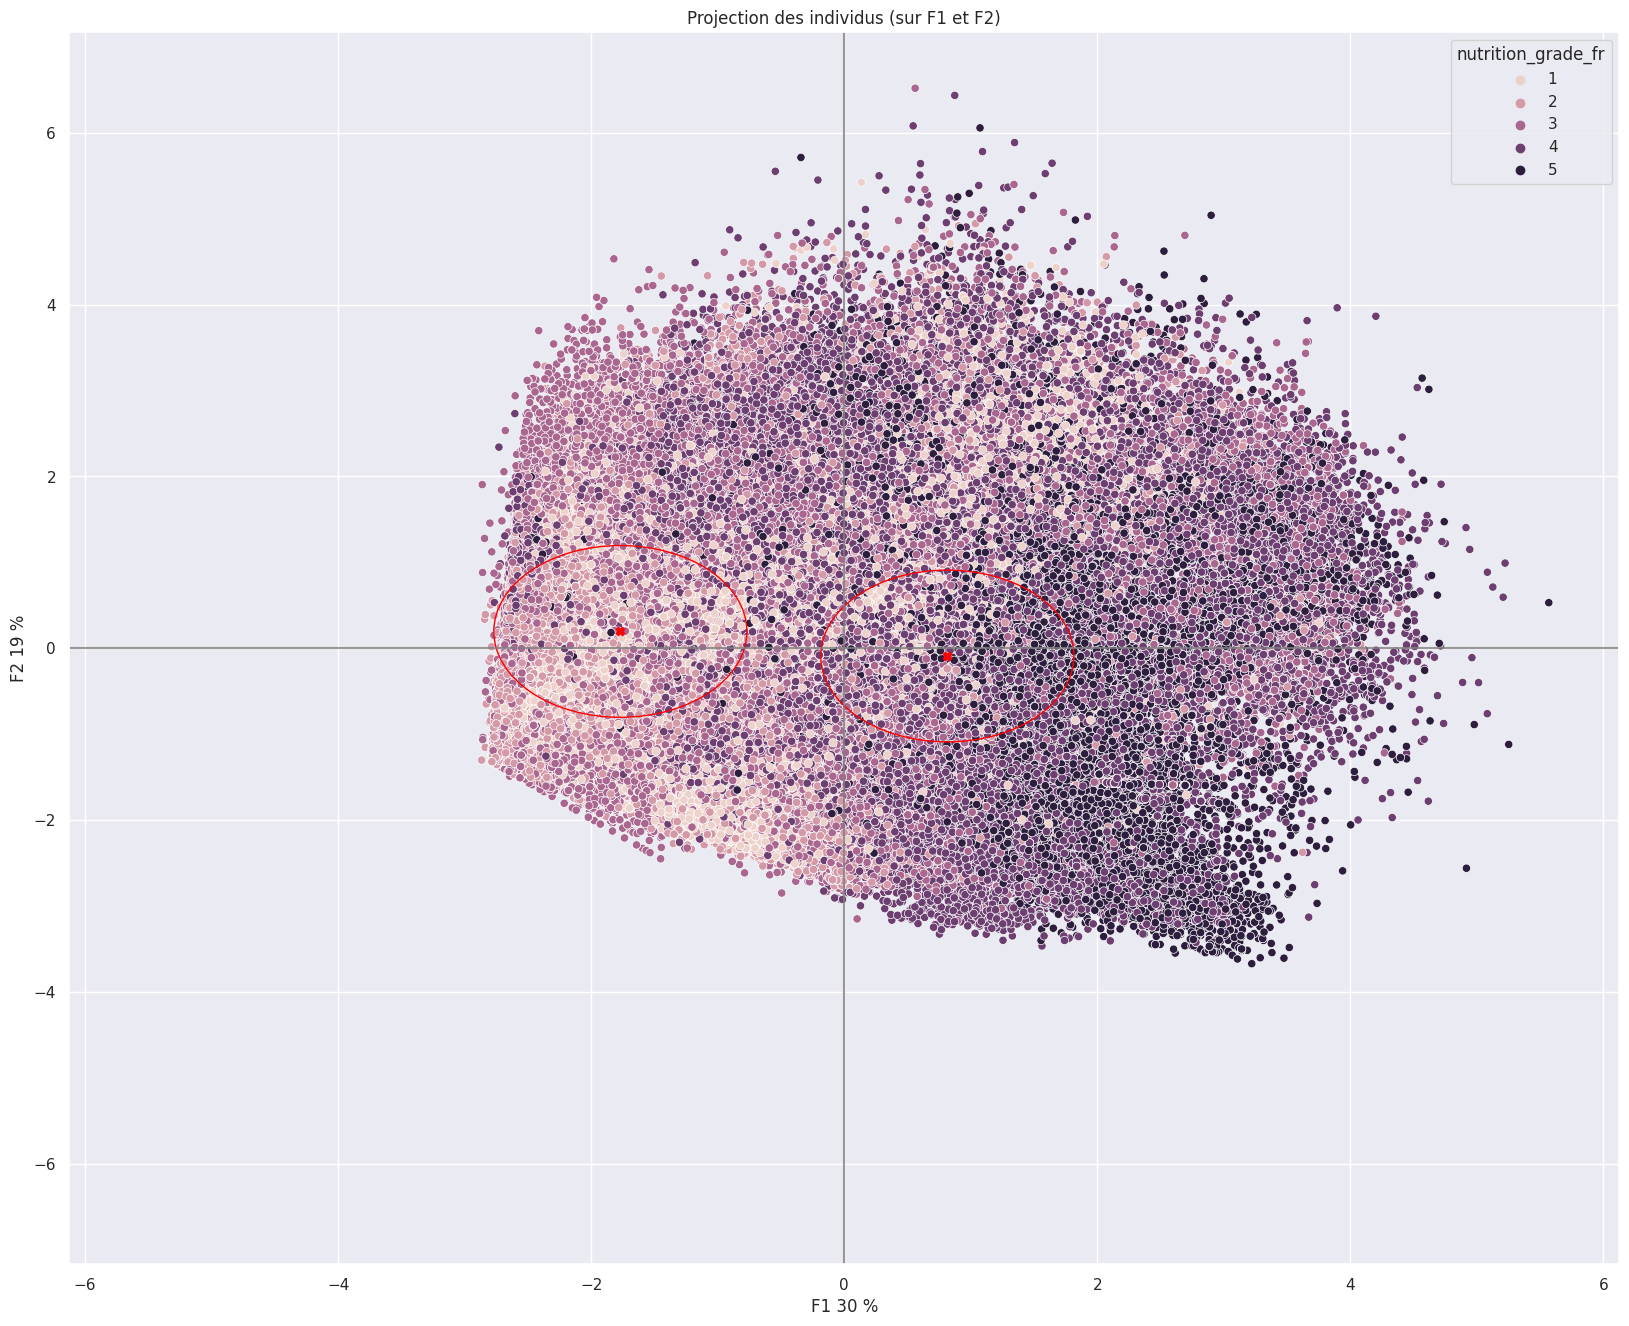

In [127]:
x_y = [0,1] # axes F1 et F2
clust_info=Find_and_plot_cluster(X_proj,2,x_y)
display_factorial_planes(X_proj, x_y, pca, labels=None,cluster_coor=clust_info[1],figsize=(20,16),
                         clusters=df_full['nutrition_grade_fr'],marker="o")

On peut bien voir que plus on regarde vers la droite (partie positive de F1) plus on retrouve d'individu au nutriscore élevé (D et E). En affichant un nombre de cluster égal à 2 cela permet de le mettre en =core mieux en évidence.

Ci-dessous les données colorées selon les clusters identifiés :

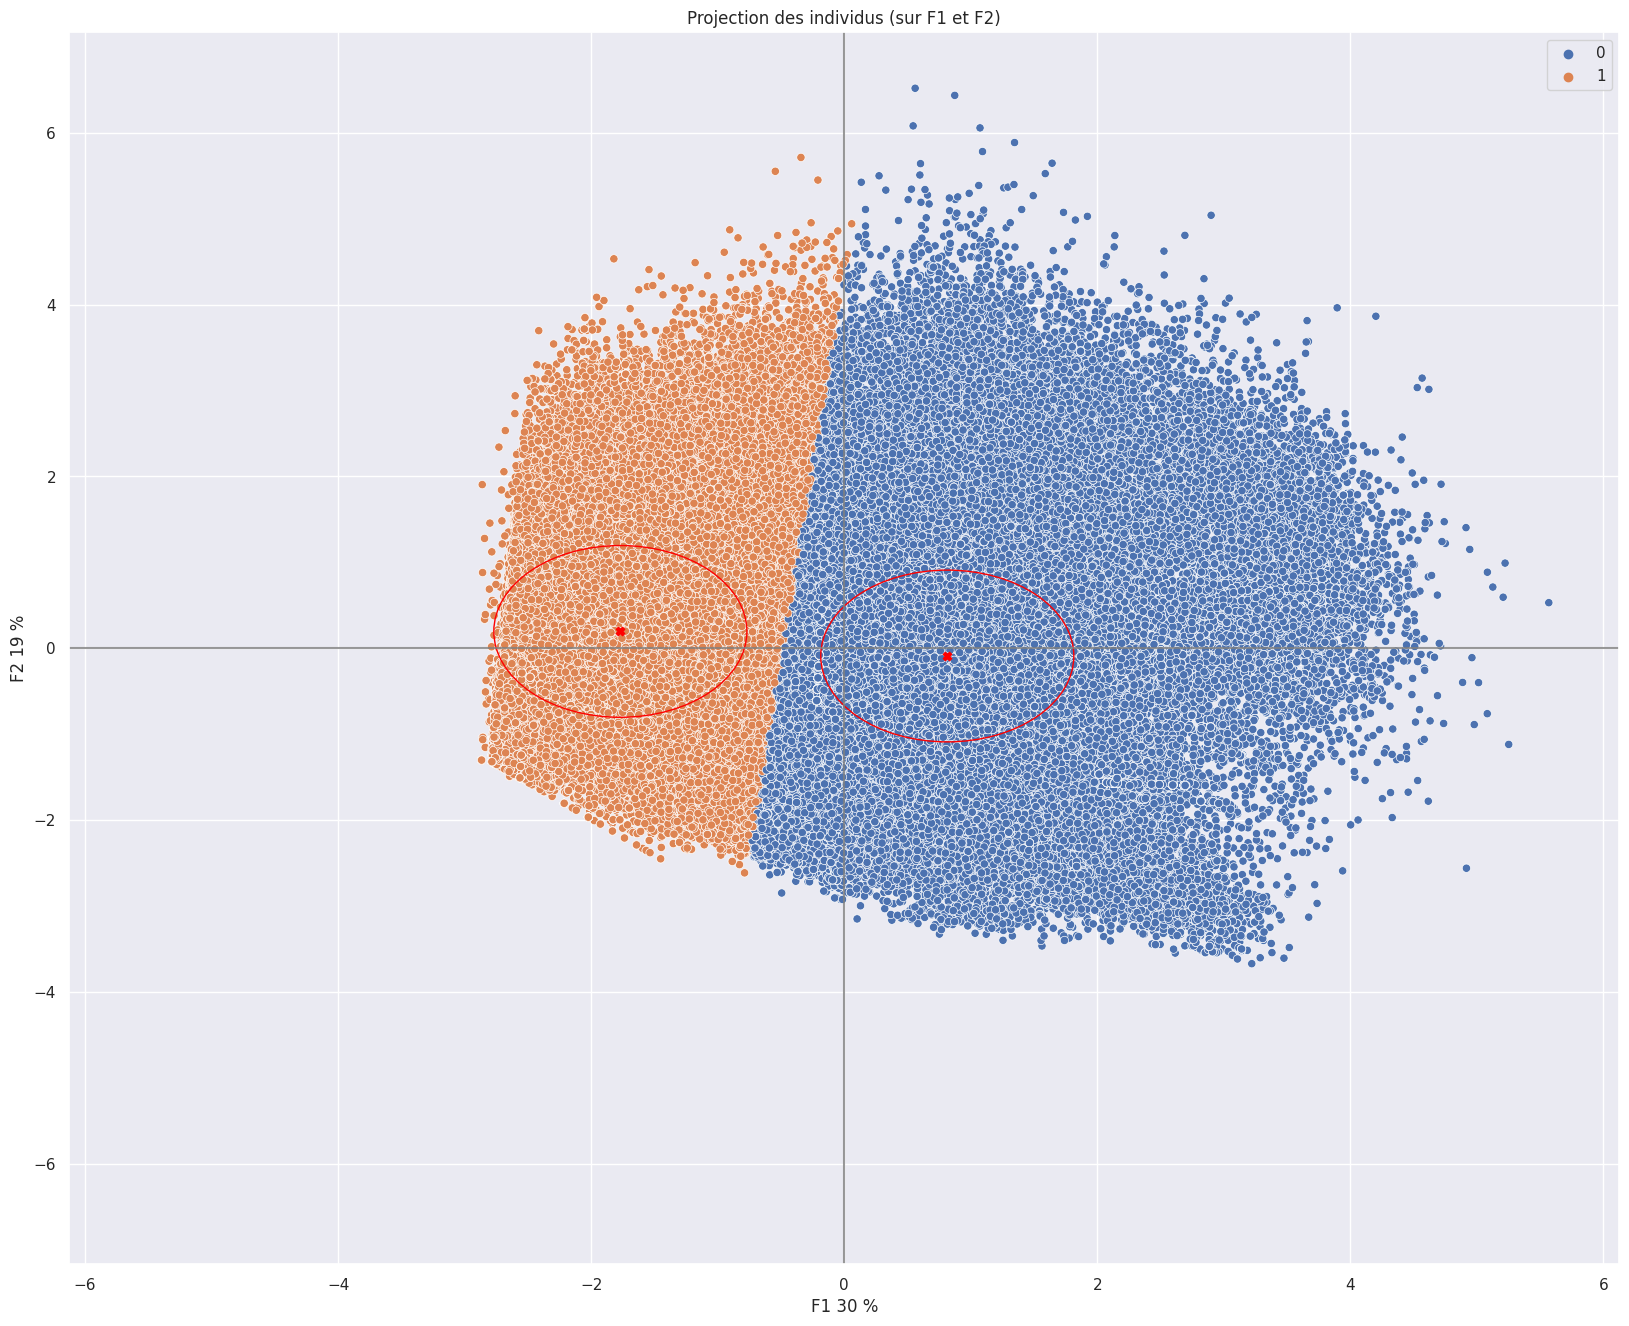

In [ ]:
x_y = [0,1]
clust_info=Find_and_plot_cluster(X_proj,2,x_y)
display_factorial_planes(X_proj, x_y, pca, labels=None,cluster_coor=clust_info[1],figsize=(20,16),
                         clusters=clust_info[0],marker="o")

Sachant que l'axe F1 est celui qui explique le mieux les variables energy_100g et fat_100g, une interprêtation possible est que plus un aliment est calorique et gras et plus sont nutri-score sera haut (D,E).

Examinons cela dans l'espace (F3, F4) :

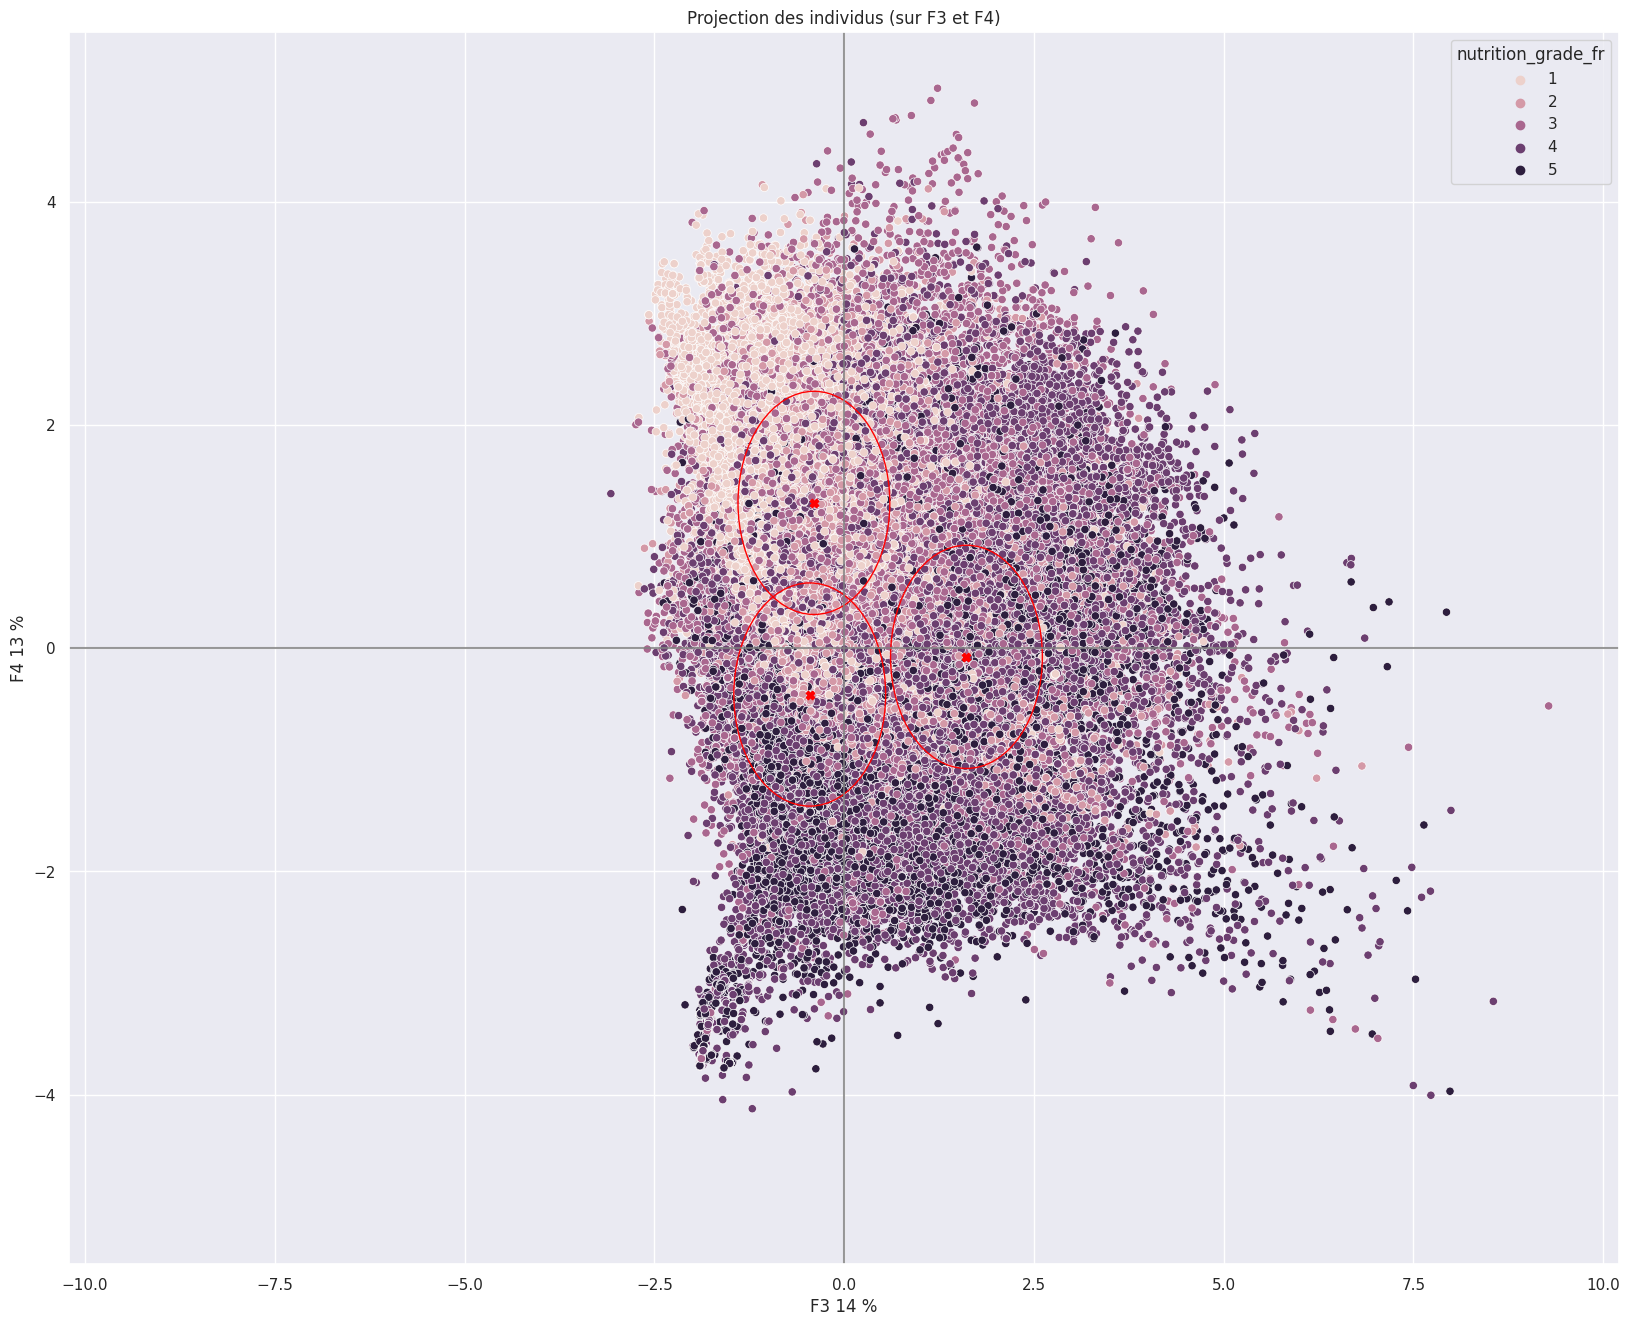

In [ ]:
# avec F3 et F4
x_y =[2,3]
clust_info=Find_and_plot_cluster(X_proj,3,x_y)
display_factorial_planes(X_proj, x_y, pca, labels=None,cluster_coor=clust_info[1],figsize=(20,16),
                         clusters=df_full['nutrition_grade_fr'],marker="o")

Sur l'affichage ci-dessous on peut distinguer environ 3 zones. L'une vers le bas (selon partie négative de F4) rassemblant d'avantage de nutriscores élevés (D et E), une seconde vers la droite (F3 positive) avec des nutriscore intermédiaires (B et C), et une troisième vers le haut (F4 positive) avec des valeurs basse (A).

Cela se met bien en évidence en fixant un nombre de cluster de 3 :

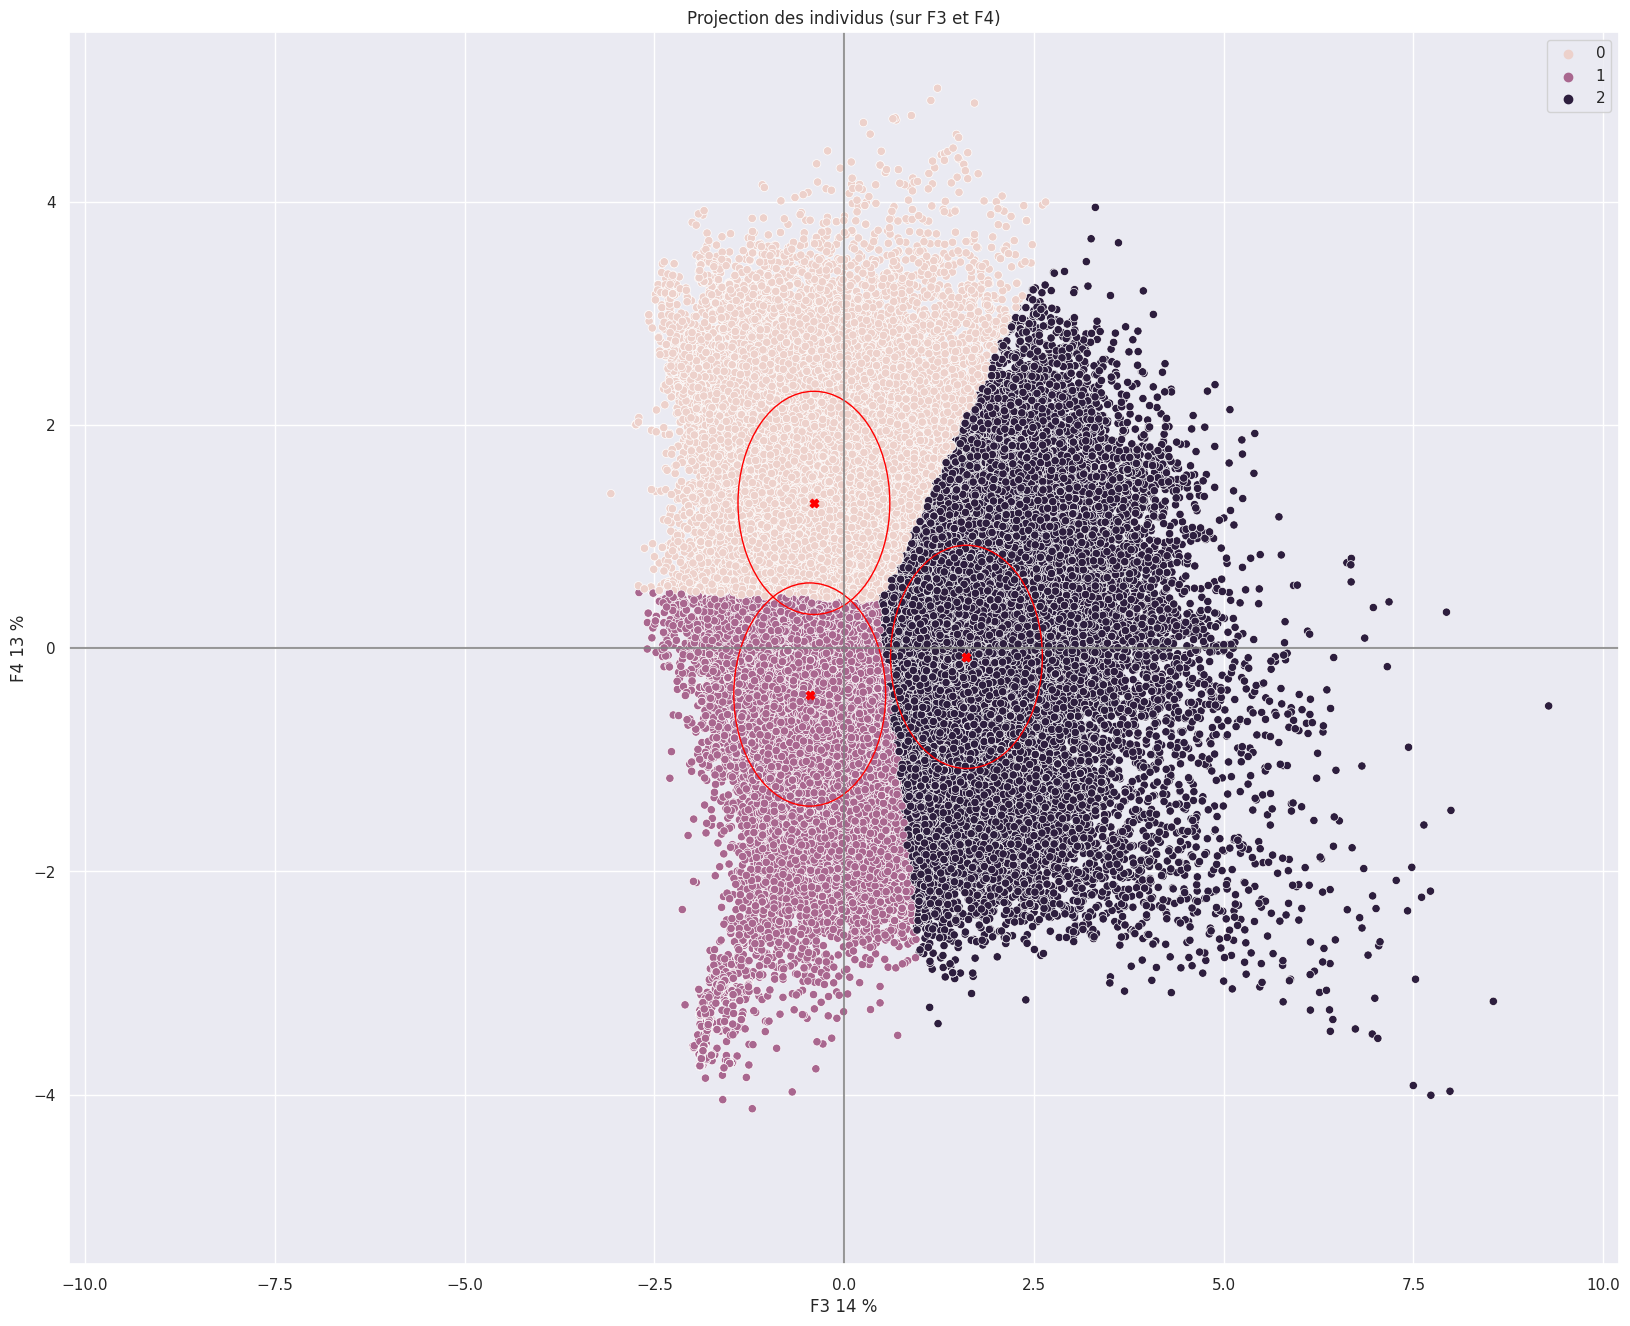

In [ ]:
x_y =[2,3] # F3 et F4
clust_info=Find_and_plot_cluster(X_proj,3,x_y)
display_factorial_planes(X_proj, x_y, pca, labels=None,cluster_coor=clust_info[1],figsize=(20,16),
                         clusters=clust_info[0],marker="o")

Une interprêtation possible est qu'une quantité de fibre importante dans un aliment contribuerait à améliorer sont nutriscore (A) et inversement (peu de fibre => E).

Aussi, une quantité importante d'additifs et de sel contribuerait à baisser sont nutriscore (C et D).

## ANOVA

Enfin dans cette partie finale nous allons comparer les distributions de chaque variable nutritionnelle selon la valeur A,B,C,D et E du nutrition-grade.

Rappel des colonnes du dataframe traité :

In [ ]:
df_full.columns

Index(['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'additives_n', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'nutrition_grade_fr'],
      dtype='object')

Plusieurs méthodes existent pour comparer statistiquement des distributions. Nous utiliserons la méthode f_oneway de scipy.stats qui nous renvoie directement la p-value à interprêter, ainsi qu'une fonction eta_squared renvoyant pour chaque variable nutrition le rapport des variances par grade nutri-score sur la variance totale.

In [ ]:
from scipy.stats import f_oneway

In [ ]:
# fonction du calcul de eta²
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

La cellule suivante permet d'afficher dans une même fenêtre les distributions de chaque variable selon le grade nutri-score ainsi que les valeurs des p-value et eta² :

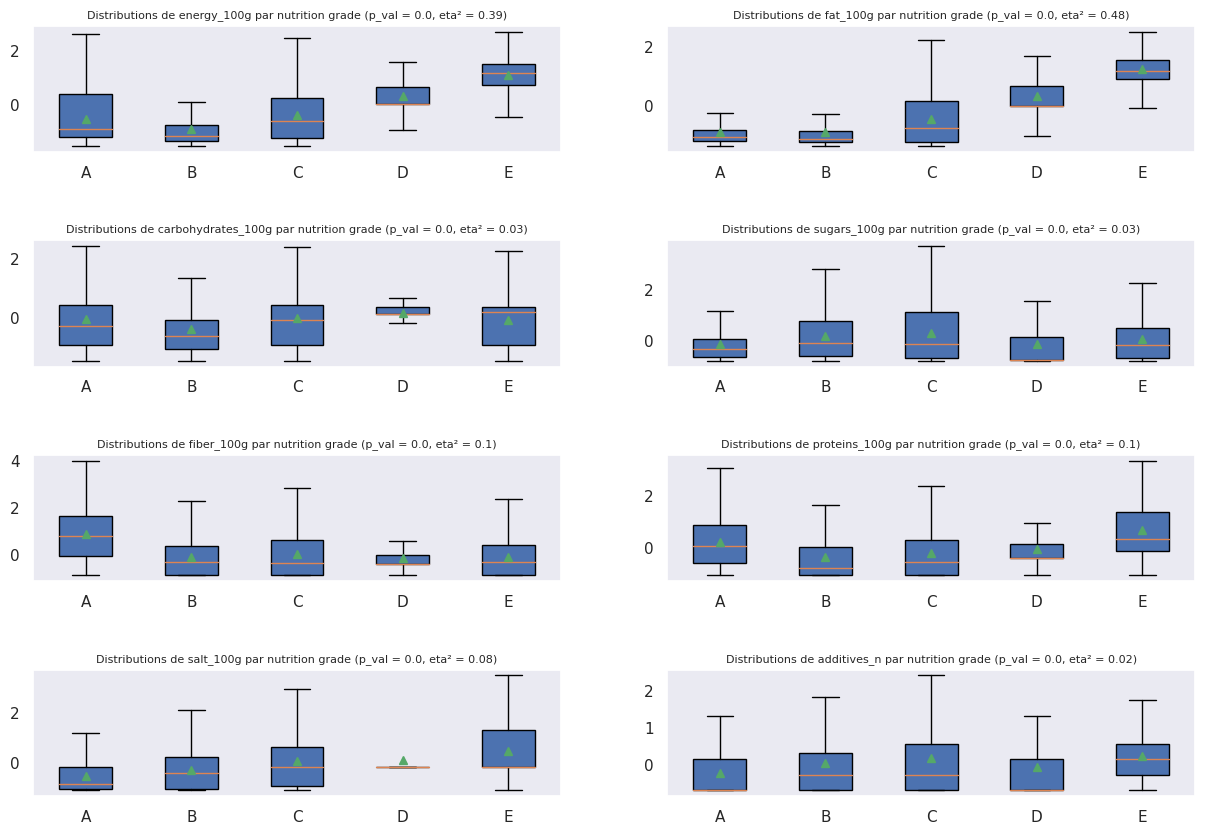

In [ ]:
# variables
feat=['energy_100g', 'fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'additives_n']
nutri_grade=sorted(df_full['nutrition_grade_fr'].value_counts().index.tolist())

# on calcul une copie normalisée de df_full pour les calculs eta² et p-value
df_scaled=pd.DataFrame(StandardScaler().fit_transform(df_full[feat+['nutrition_grade_fr']]),columns=feat+['nutrition_grade_fr'])
nutri_grade_scaled=sorted(df_scaled['nutrition_grade_fr'].value_counts().index.tolist())

# calcul des dimention du subplot en deux colonnes
f=len(feat)
h=f%2
g=1 if (f-h)!=0 else 0
a,b=int((f//2)+h),2

# plot
plt.figure(figsize=(15,10))
for p in range(len(feat)):

  df_cat=[]
  for grd in range(len(nutri_grade)):
    df_cat.append(df_scaled.loc[df_scaled['nutrition_grade_fr']==nutri_grade_scaled[grd],feat[p]])

  # on trace les distribution par grade
  plt.subplot(a,b,p+1)

  # calcul eta² et p-value de la variable
  # p-value
  p_val=f_oneway(df_cat[0],df_cat[1],df_cat[2],df_cat[3],df_cat[4])[1]
  # eta²
  eta_sqrt=eta_squared(x=df_full['nutrition_grade_fr'],y=df_full[feat[p]])

  plt.title(f"Distributions de {feat[p]} par nutrition grade (p_val = {round(p_val,2)}, eta² = {round(eta_sqrt,2)})",fontsize=8)
  plt.grid()
  plt.boxplot(df_cat,vert=True,showmeans=True,showfliers=False,patch_artist = True,labels=['A','B','C','D','E'])
  plt.gcf().subplots_adjust(hspace = 0.7,wspace = .2)


On peut s'apercevoir que l'energie et les matières grasses ont une influence sur la valeur du nutri-score notament d'après la valeur de eta² > 0.14.

On peut également noter une influence modérée des protéines et des fibre sur le nutri-score (eta²=0.1)

# RESPECT DES PRINCIPES RGPD

Montrons que la base de données Open Food Fact respect [les 5 grands principes de la RGPD](https://www.cnil.fr/fr/collectivites-territoriales/les-principes-cles-de-la-protection-des-donnees).

## 1) Finalité

Les données sont collectées pour un but bien déterminé et légitime et ne sont pas traitées ultérieurement de façon incompatible avec cet objectif initial. Ce principe limite la manière dont le responsable de traitement pourra utiliser ou réutiliser ces données dans le futur.

Open Food fact rassemble les données nutritives d'une grand nombre de produit afin de les synthétiser dans le nutri-score qui a pour but d'informer le consommateur. C'est la finalité de ces données. Open Food Fact respecte bien ce premier principe.

## 2) Pertinence

Seules les données strictement nécessaires à la réalisation de l’objectif poursuivi doivent être collectées. Il s’agit donc de minimiser autant que possible la collecte des données.

In [ ]:
# données syndées en plusieurs catégories

# traçabilité
Trace=['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
  'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_fr',
 'traces',
 'traces_tags',
 'traces_fr',
 'states',
 'states_tags',
 'states_fr']

# description

Desc=['quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'labels',
 'labels_tags',
 'labels_fr',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'allergens',
 'allergens_fr',
 'serving_size',
 'no_nutriments',
 'pnns_groups_1',
 'pnns_groups_2',
 'main_category',
 'main_category_fr',
 'image_url',
 'image_small_url']

# données nutritionnelles
nut=['no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_fr',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_oil_tags',
 'nutrition_grade_uk',
 'nutrition_grade_fr',
 'energy_100g',
 'energy-from-fat_100g',
 'fat_100g',
 'saturated-fat_100g',
 'butyric-acid_100g',
 'caproic-acid_100g',
 'caprylic-acid_100g',
 'capric-acid_100g',
 'lauric-acid_100g',
 'myristic-acid_100g',
 'palmitic-acid_100g',
 'stearic-acid_100g',
 'arachidic-acid_100g',
 'behenic-acid_100g',
 'lignoceric-acid_100g',
 'cerotic-acid_100g',
 'montanic-acid_100g',
 'melissic-acid_100g',
 'monounsaturated-fat_100g',
 'polyunsaturated-fat_100g',
 'omega-3-fat_100g',
 'alpha-linolenic-acid_100g',
 'eicosapentaenoic-acid_100g',
 'docosahexaenoic-acid_100g',
 'omega-6-fat_100g',
 'linoleic-acid_100g',
 'arachidonic-acid_100g',
 'gamma-linolenic-acid_100g',
 'dihomo-gamma-linolenic-acid_100g',
 'omega-9-fat_100g',
 'oleic-acid_100g',
 'elaidic-acid_100g',
 'gondoic-acid_100g',
 'mead-acid_100g',
 'erucic-acid_100g',
 'nervonic-acid_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'sucrose_100g',
 'glucose_100g',
 'fructose_100g',
 'lactose_100g',
 'maltose_100g',
 'maltodextrins_100g',
 'starch_100g',
 'polyols_100g',
 'fiber_100g',
 'proteins_100g',
 'casein_100g',
 'serum-proteins_100g',
 'nucleotides_100g',
 'salt_100g',
 'sodium_100g',
 'alcohol_100g',
 'vitamin-a_100g',
 'beta-carotene_100g',
 'vitamin-d_100g',
 'vitamin-e_100g',
 'vitamin-k_100g',
 'vitamin-c_100g',
 'vitamin-b1_100g',
 'vitamin-b2_100g',
 'vitamin-pp_100g',
 'vitamin-b6_100g',
 'vitamin-b9_100g',
 'folates_100g',
 'vitamin-b12_100g',
 'biotin_100g',
 'pantothenic-acid_100g',
 'silica_100g',
 'bicarbonate_100g',
 'potassium_100g',
 'chloride_100g',
 'calcium_100g',
 'phosphorus_100g',
 'iron_100g',
 'magnesium_100g',
 'zinc_100g',
 'copper_100g',
 'manganese_100g',
 'fluoride_100g',
 'selenium_100g',
 'chromium_100g',
 'molybdenum_100g',
 'iodine_100g',
 'caffeine_100g',
 'taurine_100g',
 'ph_100g',
 'fruits-vegetables-nuts_100g',
 'collagen-meat-protein-ratio_100g',
 'cocoa_100g',
 'chlorophyl_100g',
 'carbon-footprint_100g',
 'nutrition-score-fr_100g',
 'nutrition-score-uk_100g',
 'glycemic-index_100g',
 'water-hardness_100g']

Les données récoltées peuvent être résumées en trois grande catégories.

Un tier des données caractérisent globalement la traçabilité des produits tel que le code produit, le lieu d'origine, la date d'enregistrement etc.

un second tier fourni plutôt des informations descriptives sur les produits tel que le type de packaging, la marque et la catégorie alimentaire.

Le dernier tier nous renseigne sur les quantités nutritionnelles des produits.

Toutes ces informations permette de comprendre les produits et ne servent pas à d'autres buts.

En ce sens, Open Food Fact respecte également ce second principe.

## 3) Durée limitée

Les données ne doivent être conservées sous une forme identifiante et en « base active » que le temps nécessaire à la réalisation de l’objectif poursuivi et doivent être par la suite détruites, anonymisées ou archivées dans le respect des obligations légales applicables en matière de conservation des archives publiques.

Les données récoltées sont anonymes dans le sens où elles ne permettent pas de remonter jusqu'à l'individu.

Open Food Fact respecte également le principe de durée limitées car il n'y a pas d'information identifiante.

## 4) Sécurité

Le responsable de traitement de la collectivité doit prendre toutes les mesures utiles pour garantir l’intégrité et la confidentialité de ces données, en s’assurant notamment que des tiers non autorisés n’y auront pas accès. Ces mesures seront déterminées en fonction des risques (sensibilité des données, objectif du traitement) et seront à la fois d’ordre physique, logique, technique et organisationnel (sécurisation des locaux, armoires et postes de travail, gestion stricte des habilitations et droits d’accès informatiques, encadrement des opérations sous-traitées).

La base de données Open Food Fact est à but non lucratif, ouvert à tous et pour tous et ne contenant aucun données sensibles sur les personnes.

Ce principe est donc respecté.

## 5) Droit de personnes

Les personnes concernées par les traitements doivent conserver la maitrise des données qui les concernent. Ainsi, la loi prévoit que les données ne peuvent être collectées à l’insu des personnes concernées, qui doivent avoir été informées au préalable de cette opération, de sa finalité, des destinataires des données et des modalités d’exercice de leurs droits. Ces droits « Informatique et Libertés », qu’elles peuvent exercer auprès de la collectivité qui détient ces informations sont :

le droit d’accéder à leurs données et d’en obtenir une copie ;
le droit de les rectifier
le droit de s’opposer à leur utilisation, sauf si le traitement répond à une obligation légale (par exemple, un administré ne peut s’opposer à figurer dans un fichier d’état civil).
La loi pour une République numérique d’octobre 2016 est venue renforcer ces droits en prévoyant notamment la possibilité pour les personnes concernées de les exercer par voie électronique, ainsi que de donner des directives relatives à la conservation, à l'effacement et à la communication de leurs données après leur décès.

Les données sont ouvertes à tous et n'appartiennent à personne.

Open Food Fact n'enfreint donc pas ce dernier principe.

# CONCLUSION

Les données Open food fact ont un grand nombre de valeurs manquantes.

Toutefois il est possible de réaliser un travail de nettoyage par connaissance métier et traitement statistique en gardant une certaine cohérence dans les distributions des variables.

Les variables catégorielles sont peu nombreuses et peu renseignées (pnns_group_1 et 2) et ont malheureusement été retirées de l'analyse.
Toutefois, il serait tout-à-fait possible de numériser le contenu de ces catégories et d'entraîner un modèle de KNNClassifier par exemple afin de remplir les valeurs manquante dans ces colonnes.

Les analyses statistiques et d'inertie montrent que la cohérence des données est plutôt bien conservée après tout le processus de nettoyage réalisé.

ainsi, on peut dire qu'u un tel outil d'auto-complétion est réalisable sur ces données afin de faciliter la saisi de nouveau produit.